In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)
%matplotlib inline

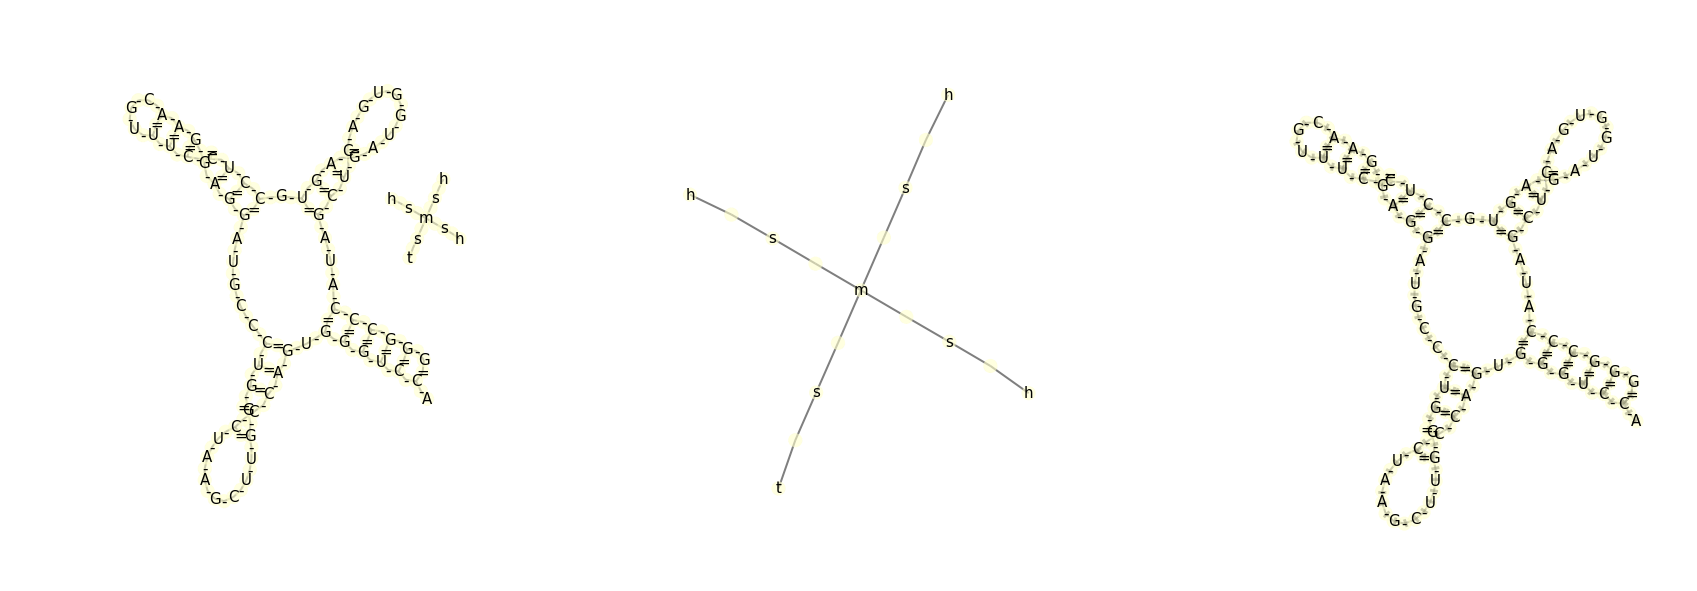

In [21]:
'''
first we need a graph delivery system. 
'''
from graphlearn.utils import draw
import graphlearn.abstract_graphs.graphmanager as graphman
from eden.graph import Vectorizer
vectorizer = Vectorizer()

graphman_iter = graphman.fromfasta('RF00005.fa',vectorizer)
graph_manager = graphman_iter.next()
graphlist=[graph_manager.get_estimateable(),graph_manager.get_abstract_graph(),graph_manager.get_base_graph()]
draw.graphlearn_draw(graphlist, size = 10,vertex_label = 'label',contract = False)


show RNA structure


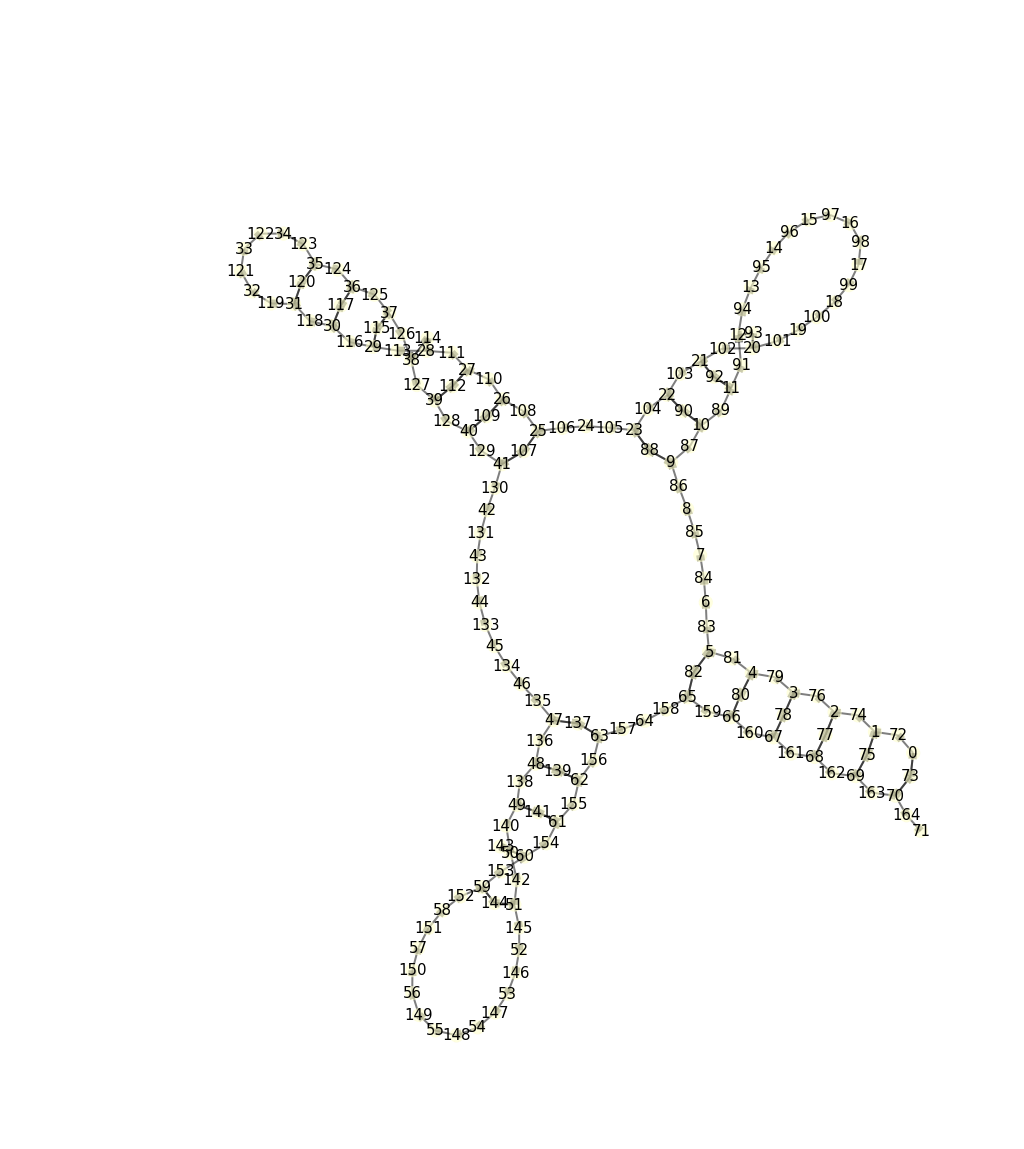

show abstract graph with associated nodes in the base graph


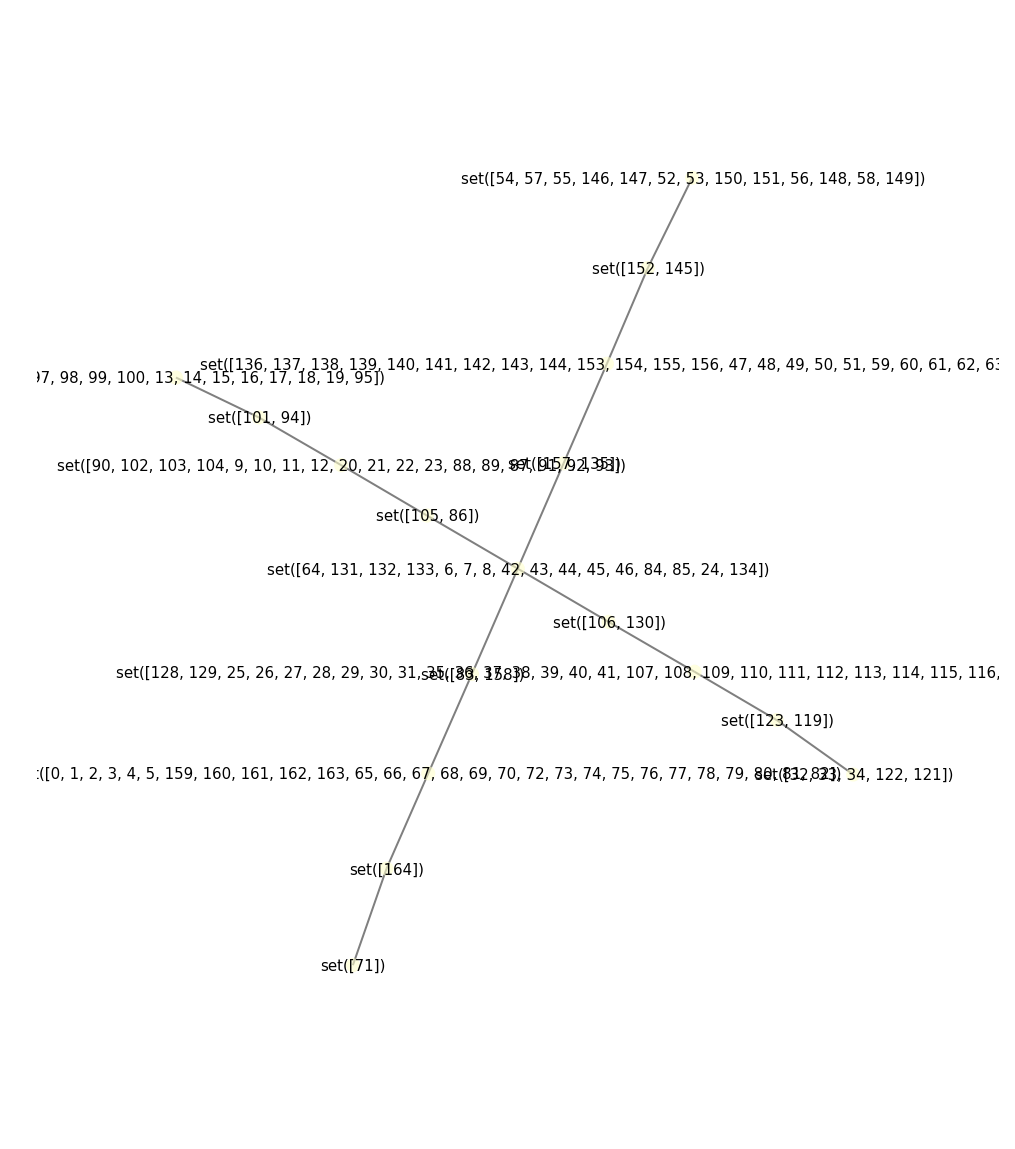

show some "cips", red nodes ~> "core", yellow ~> "interface"


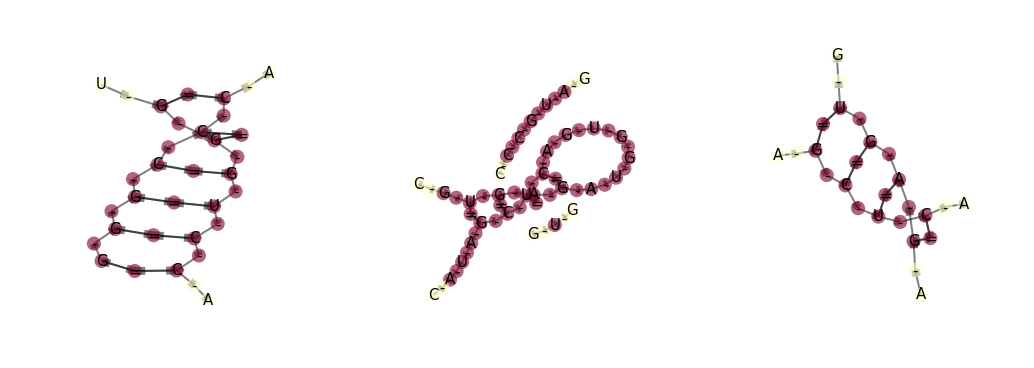

In [22]:
'''
graphlearn creates graphs given examples. 
for graphlearn to work we need to extract subgraphs of these examples that will be used later to construct new graphs.
I demonstrate this here.
'''
%matplotlib inline
import graphlearn.abstract_graphs.ubergraphlearn as ugly

print 'show RNA structure'
draw.graphlearn_draw(graph_manager.get_base_graph(),vertex_label='id',size=20)
print 'show abstract graph with associated nodes in the base graph'
draw.graphlearn_draw(graph_manager.get_abstract_graph(),vertex_label='contracted',size=20)


# prepare arguments to demonstracte the subgraph extraction
radius_list=[0,2]
thickness_list=[2,4]
base_thickness_list=[2]
args=(graph_manager,radius_list,thickness_list,Vectorizer(),2**20-1,lambda x,y:True, base_thickness_list)

# extract all subgraphs , note that the extraction is happening according to the abstract graph
cips=ugly.extract_cores_and_interfaces_mk2(args)

print 'show some "cips", red nodes ~> "core", yellow ~> "interface"'
draw.graphlearn_draw([cips[0][0].graph,cips[1][1].graph,cips[1][2].graph ], contract=False)


In [25]:
%%time
'''
preparing for sampling by 
1. training a SVM on the combination of abstract graph and base graph
2. extracting all the cips that are available in the input.
'''
import os 
os.nice(20)
%matplotlib inline

import graphlearn.abstract_graphs.rnasampler as rspl
import graphlearn.abstract_graphs.rnaabstract as rnaa
import itertools
import graphlearn.abstract_graphs.graphmanager as graphman

sampler=rspl.RNASampler(radius_list=[0,1],thickness_list=[1],base_thickness_list=[1], min_cip_count=1, min_interface_count=2, postprocessor=rnaa.ForgiPostprocessor())
graphs=graphman.fromfasta('RF00005.fa',sampler.vectorizer)
graphs=itertools.islice(graphs,100)
sampler.fit(graphs,n_jobs=1,batch_size=1)
sampler.save('tmp/rna_ubergrammar.ge')

CPU times: user 1min 19s, sys: 5.33 s, total: 1min 24s
Wall time: 2min 16s


interface id: 895847 [55 options]


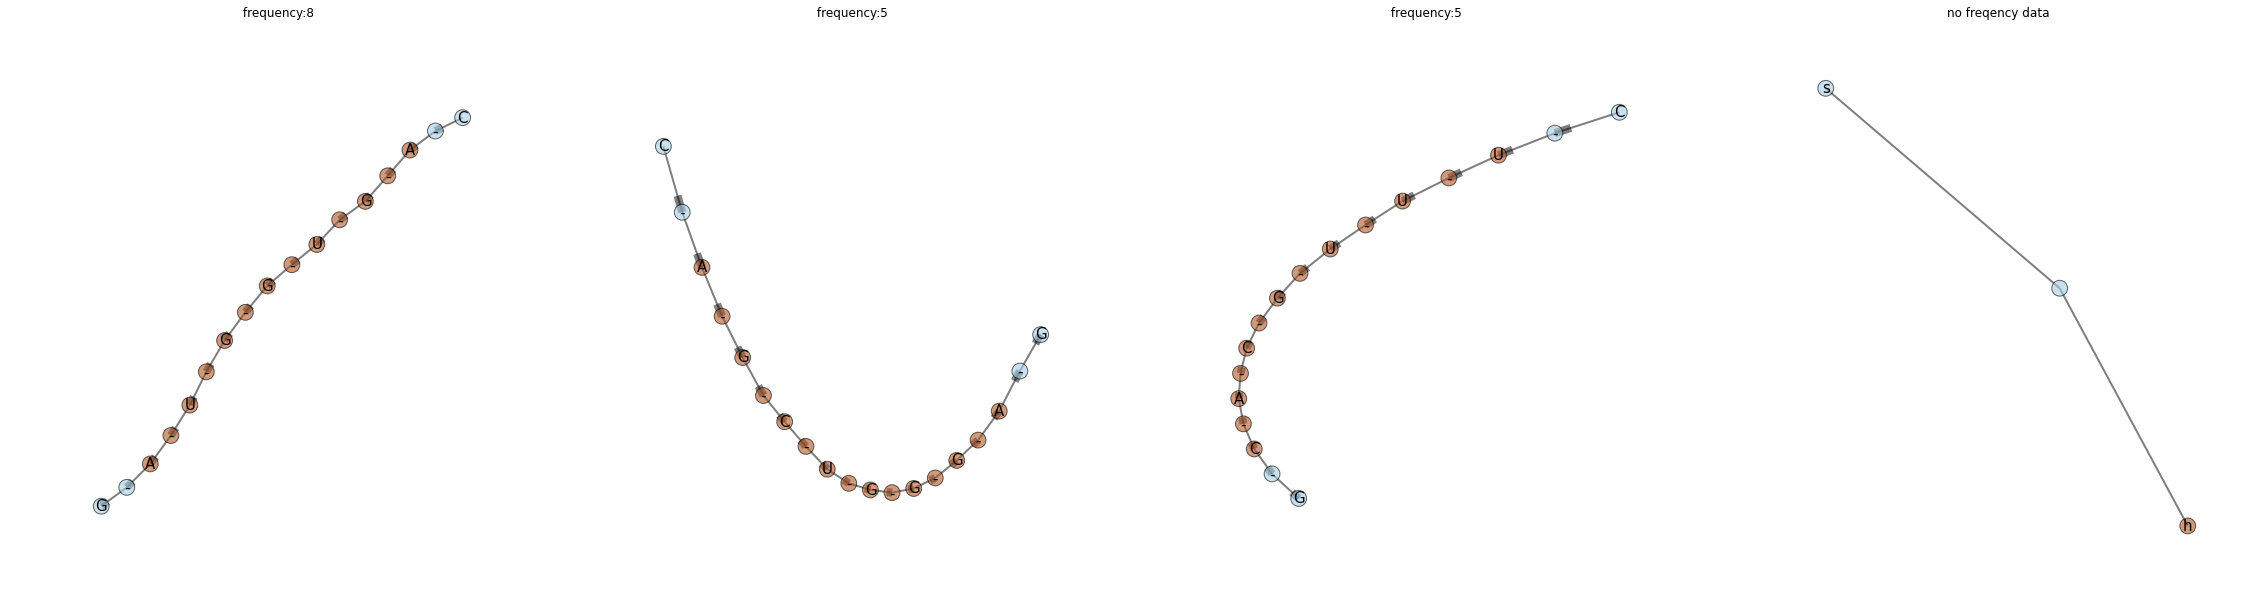

interface id: 829207 [46 options]


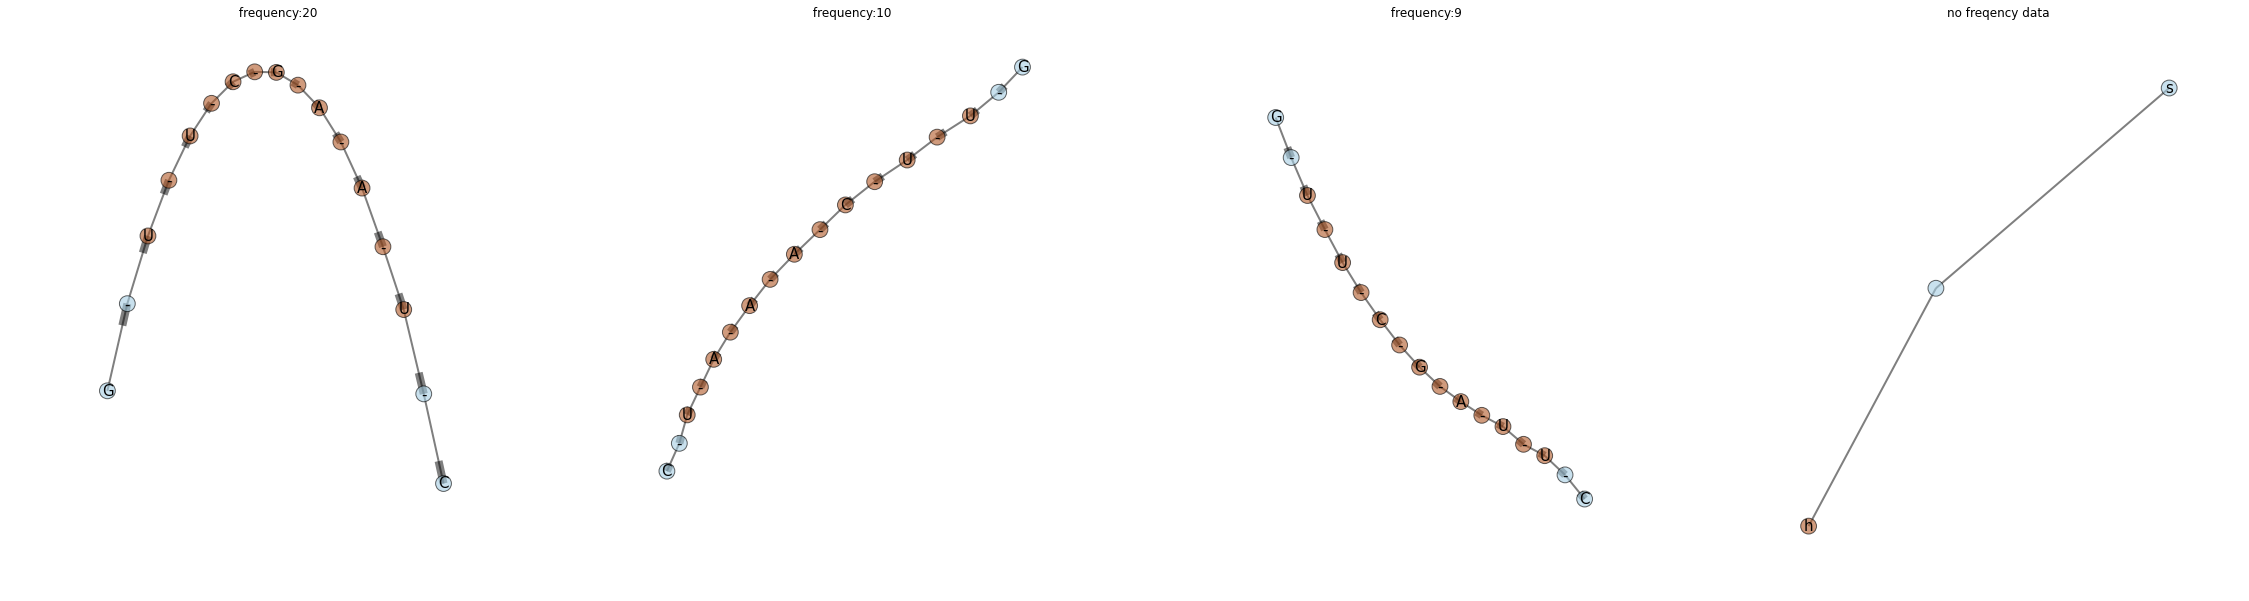

interface id: 508438 [46 options]


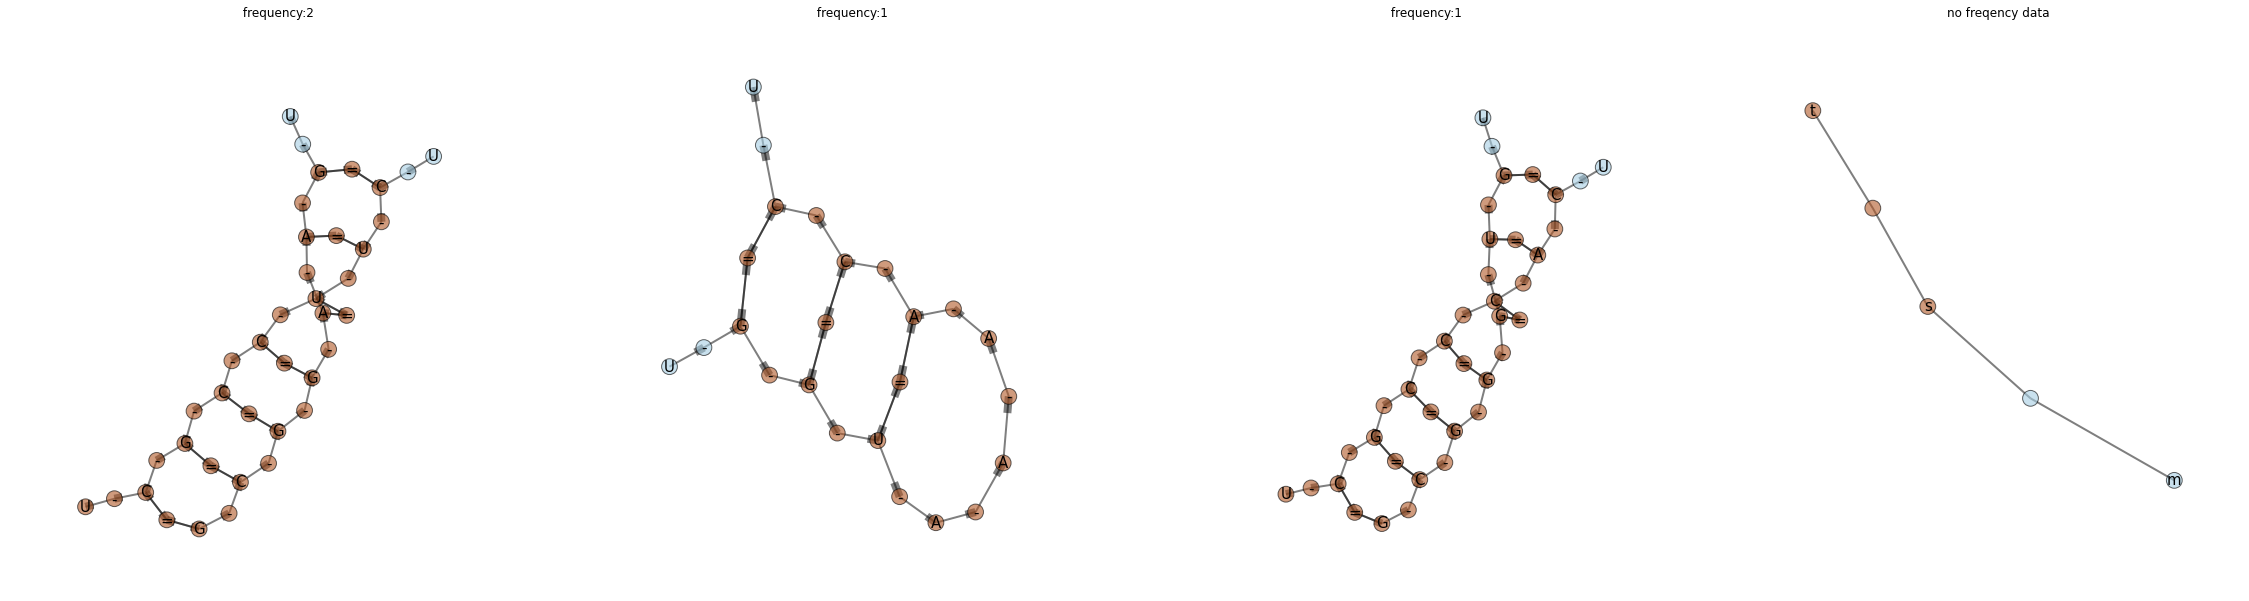

interface id: 158444 [46 options]


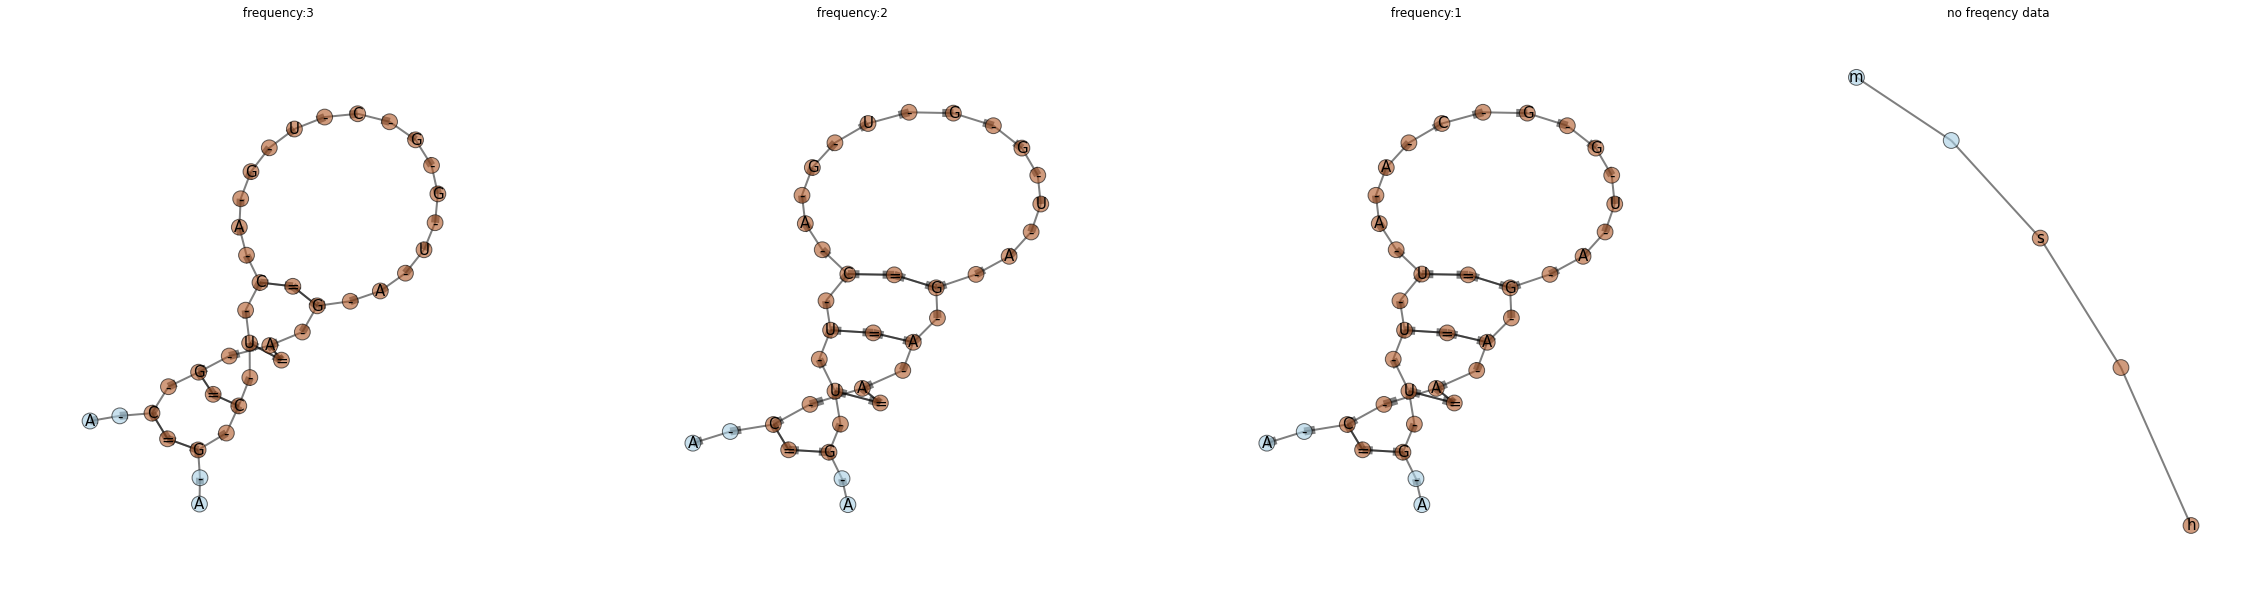

interface id: 782547 [45 options]


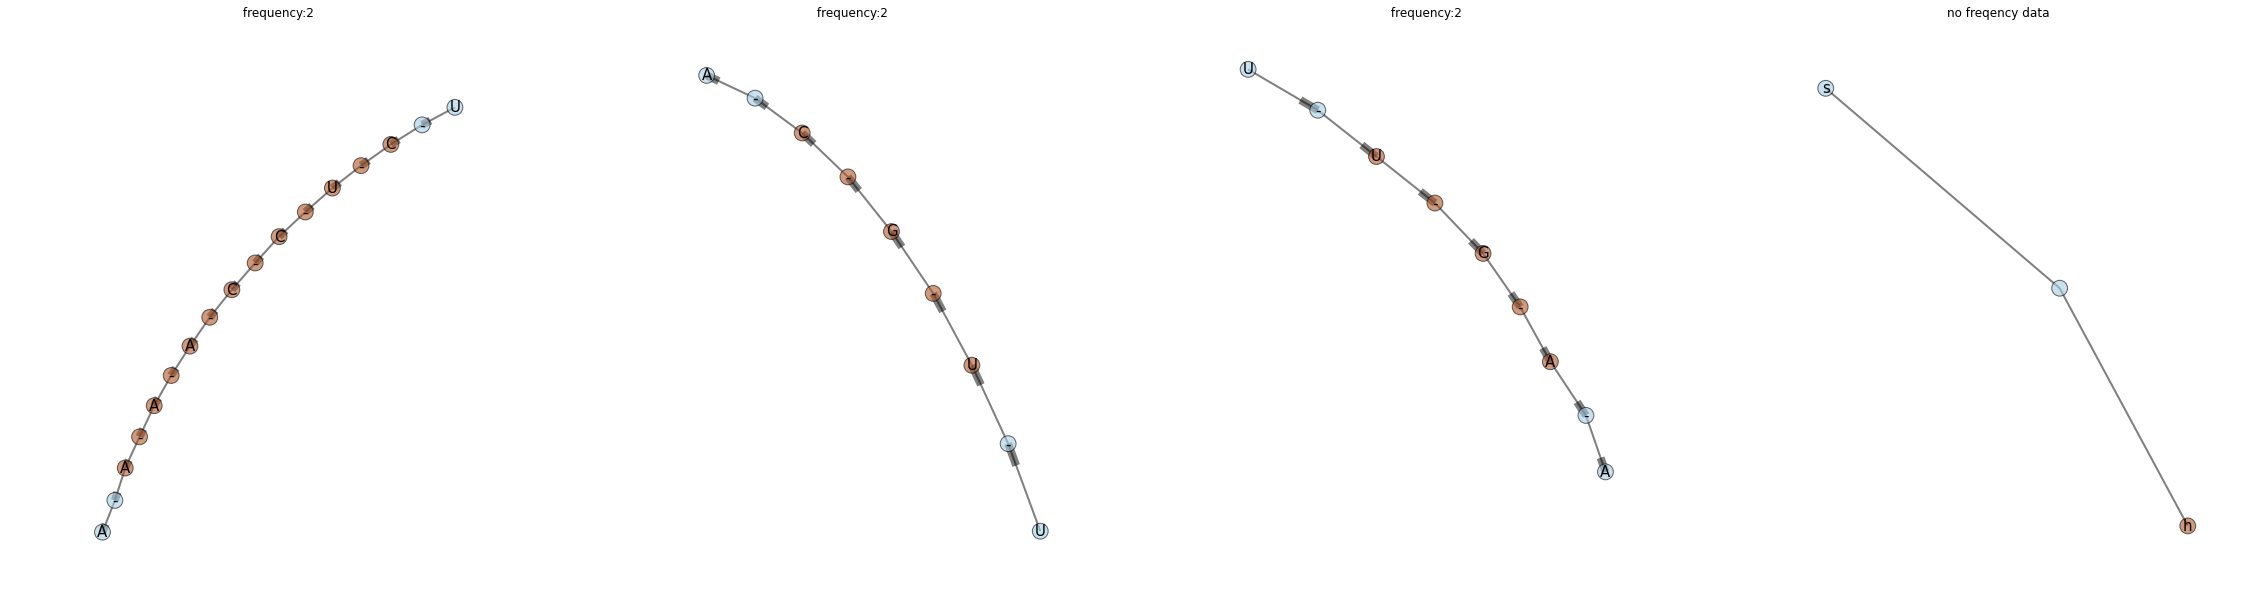

interface id: 772946 [42 options]


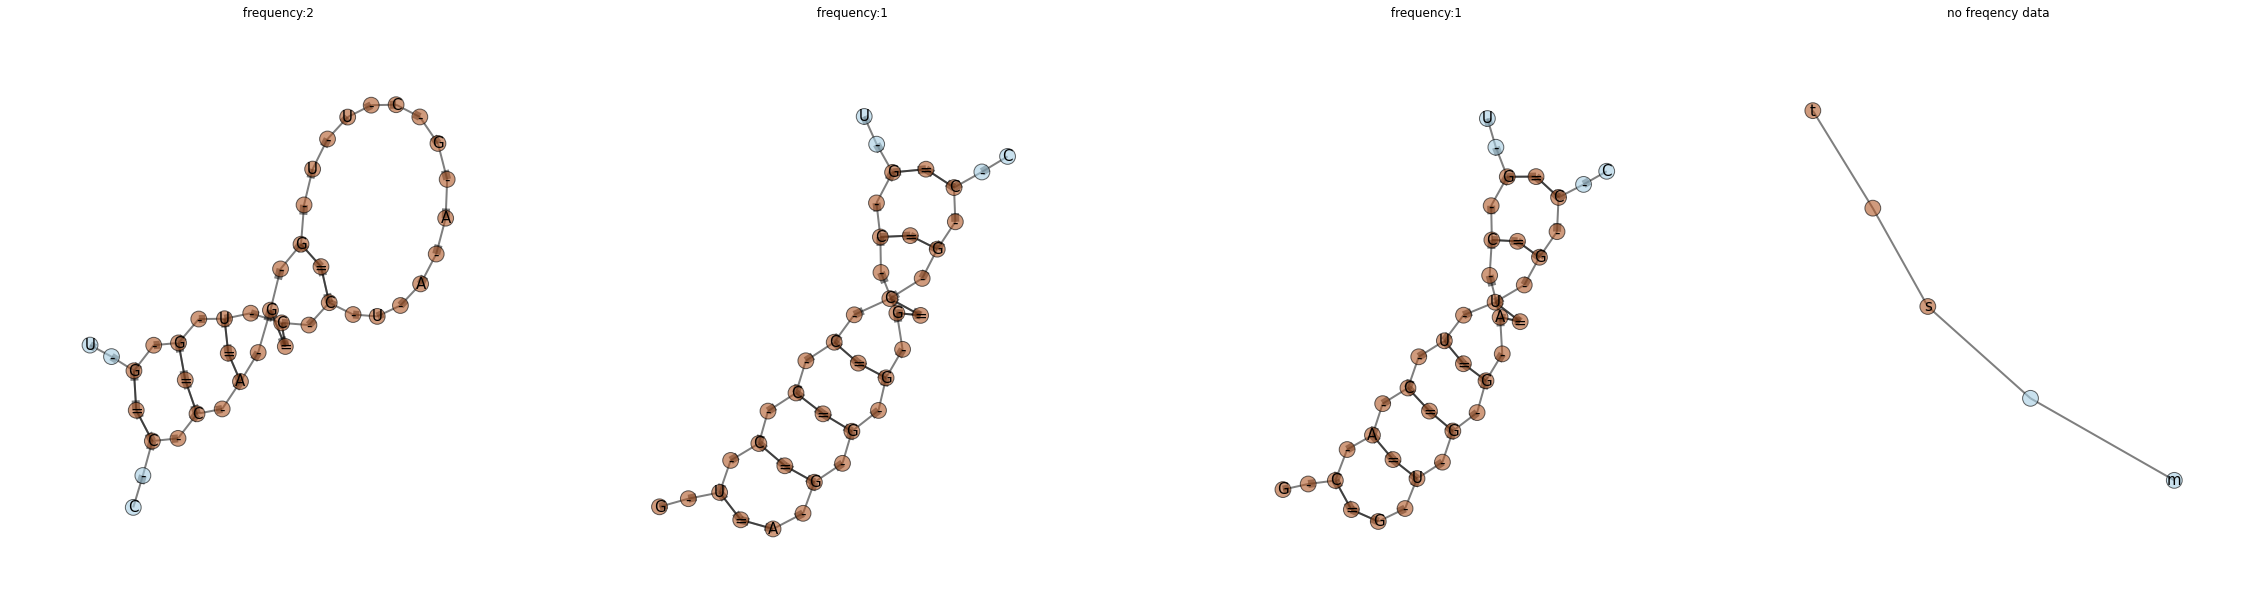

interface id: 1021485 [40 options]


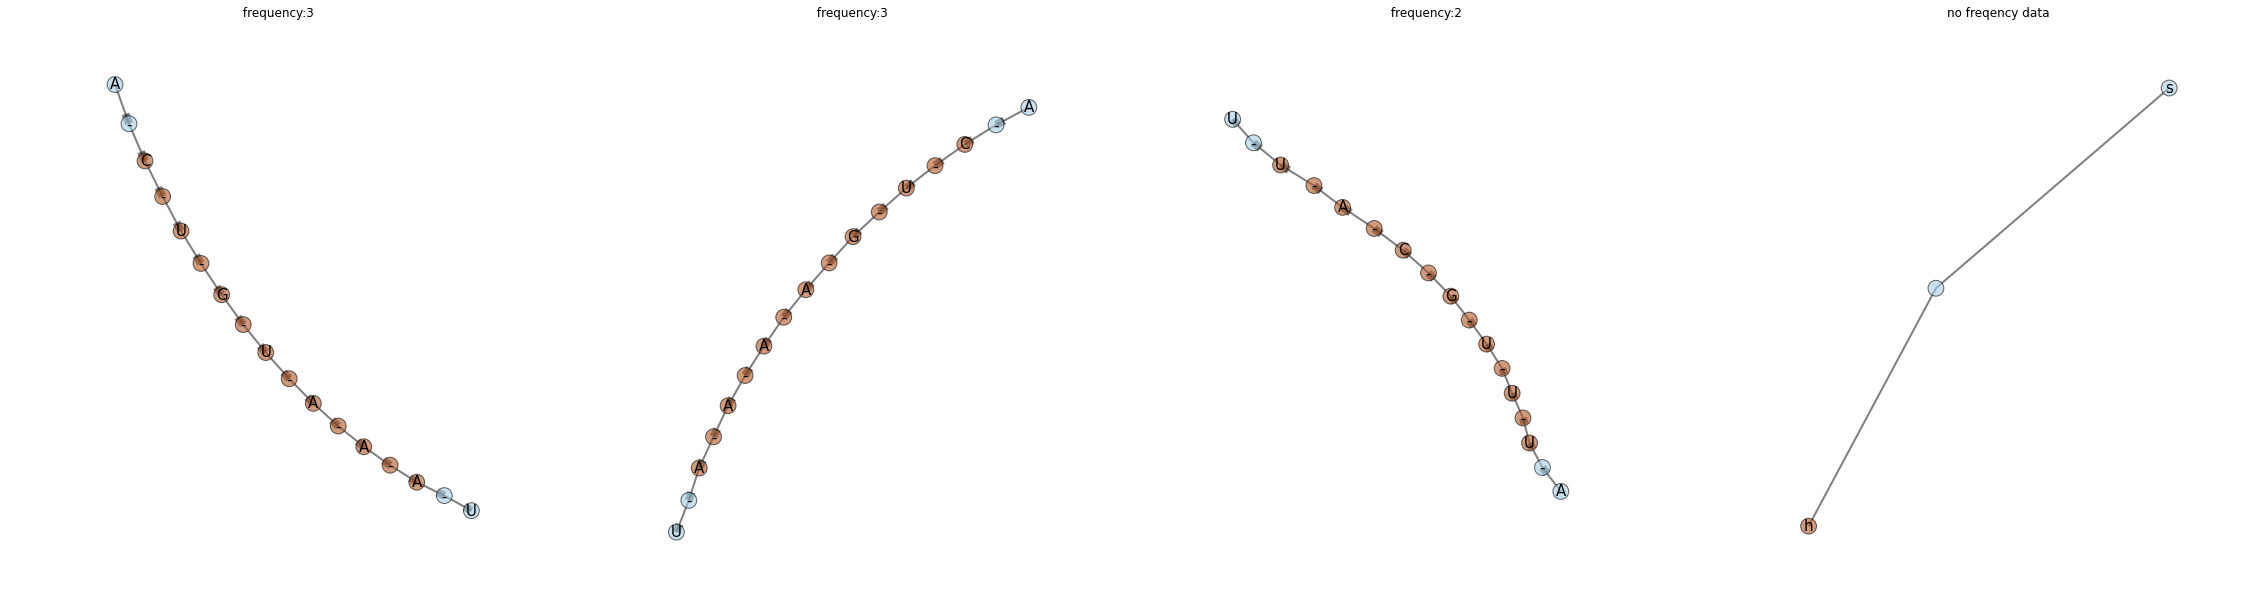

interface id: 429596 [35 options]


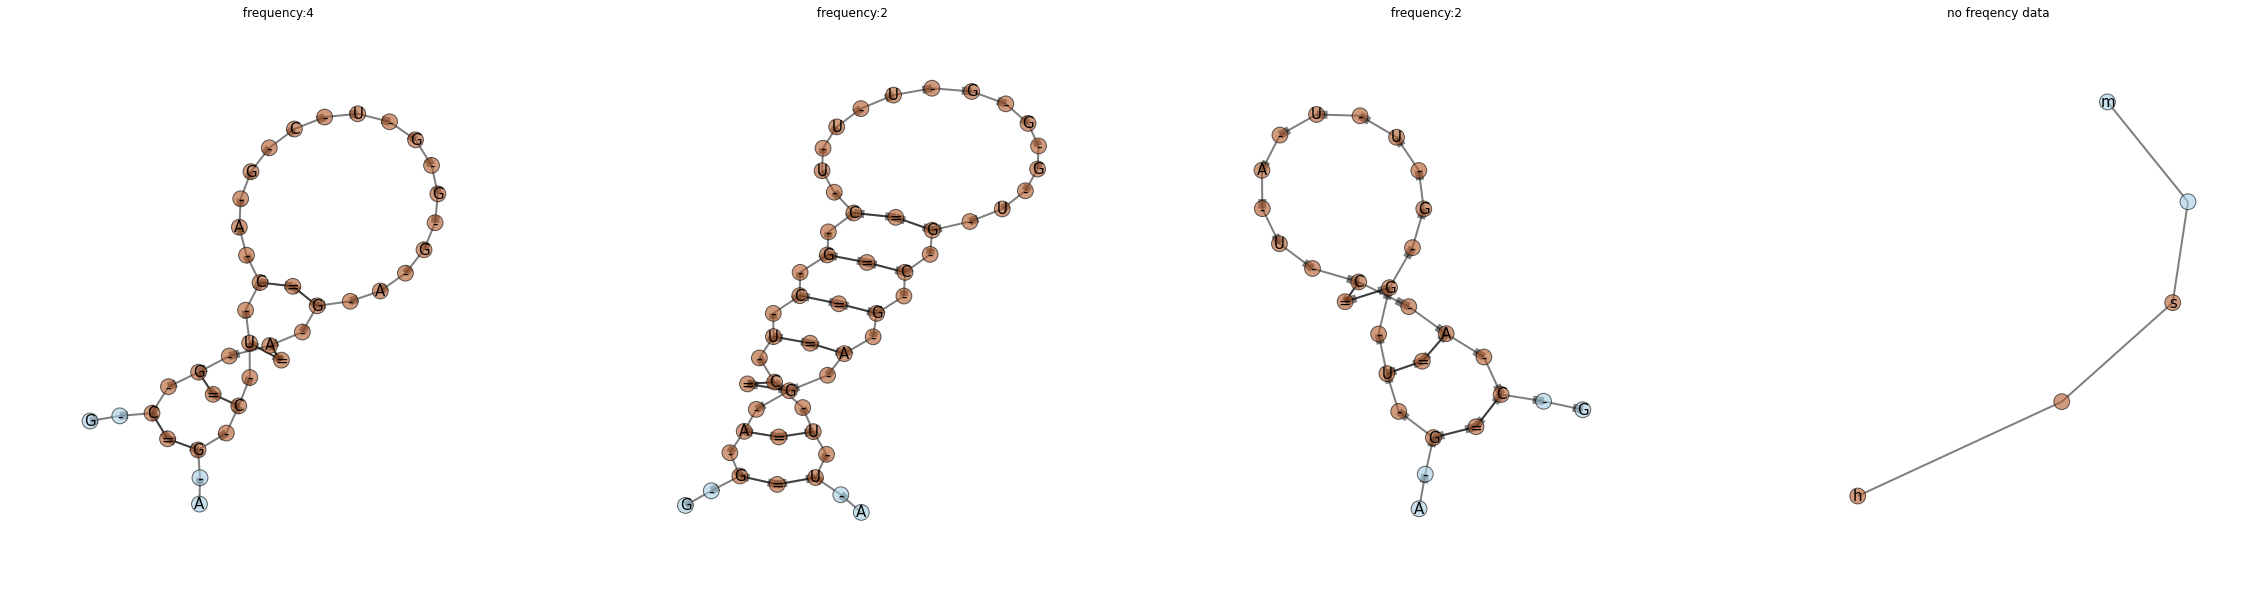

interface id: 768372 [32 options]


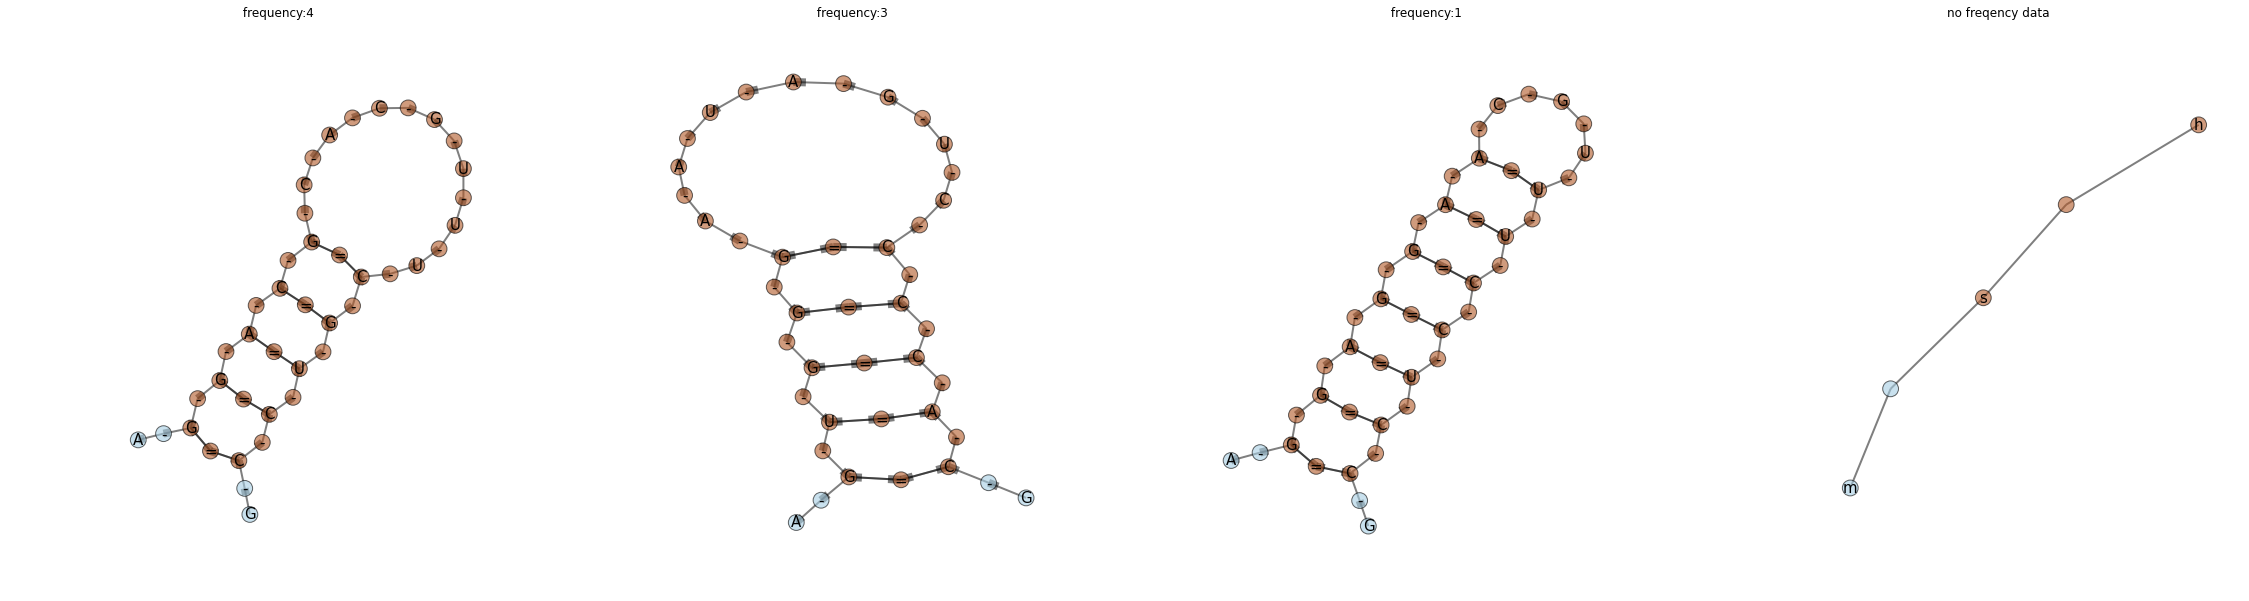

interface id: 84584 [28 options]


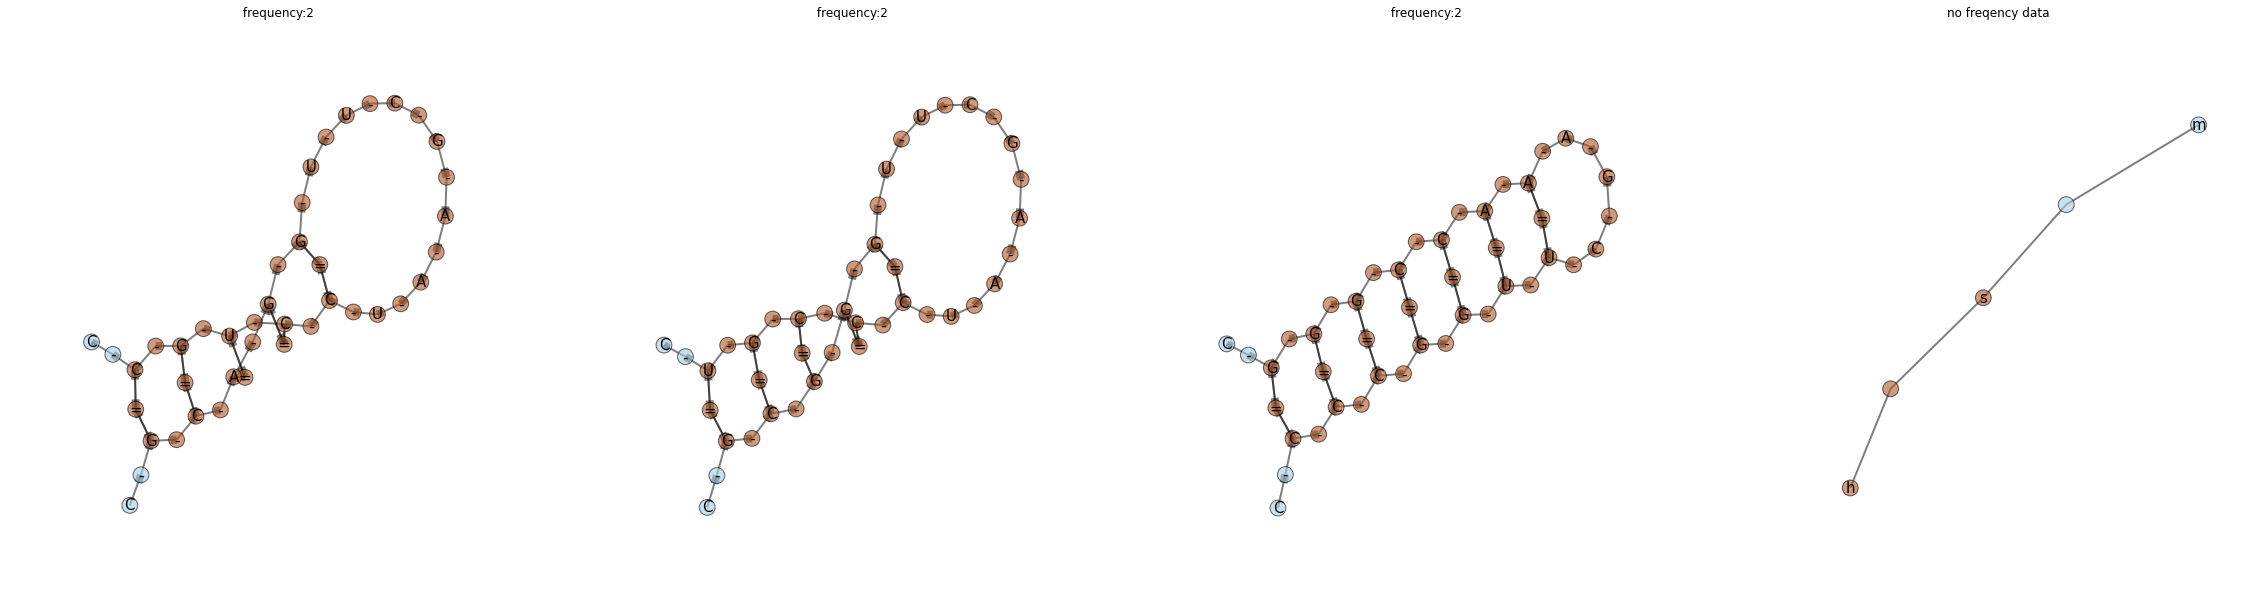

interface id: 150508 [24 options]


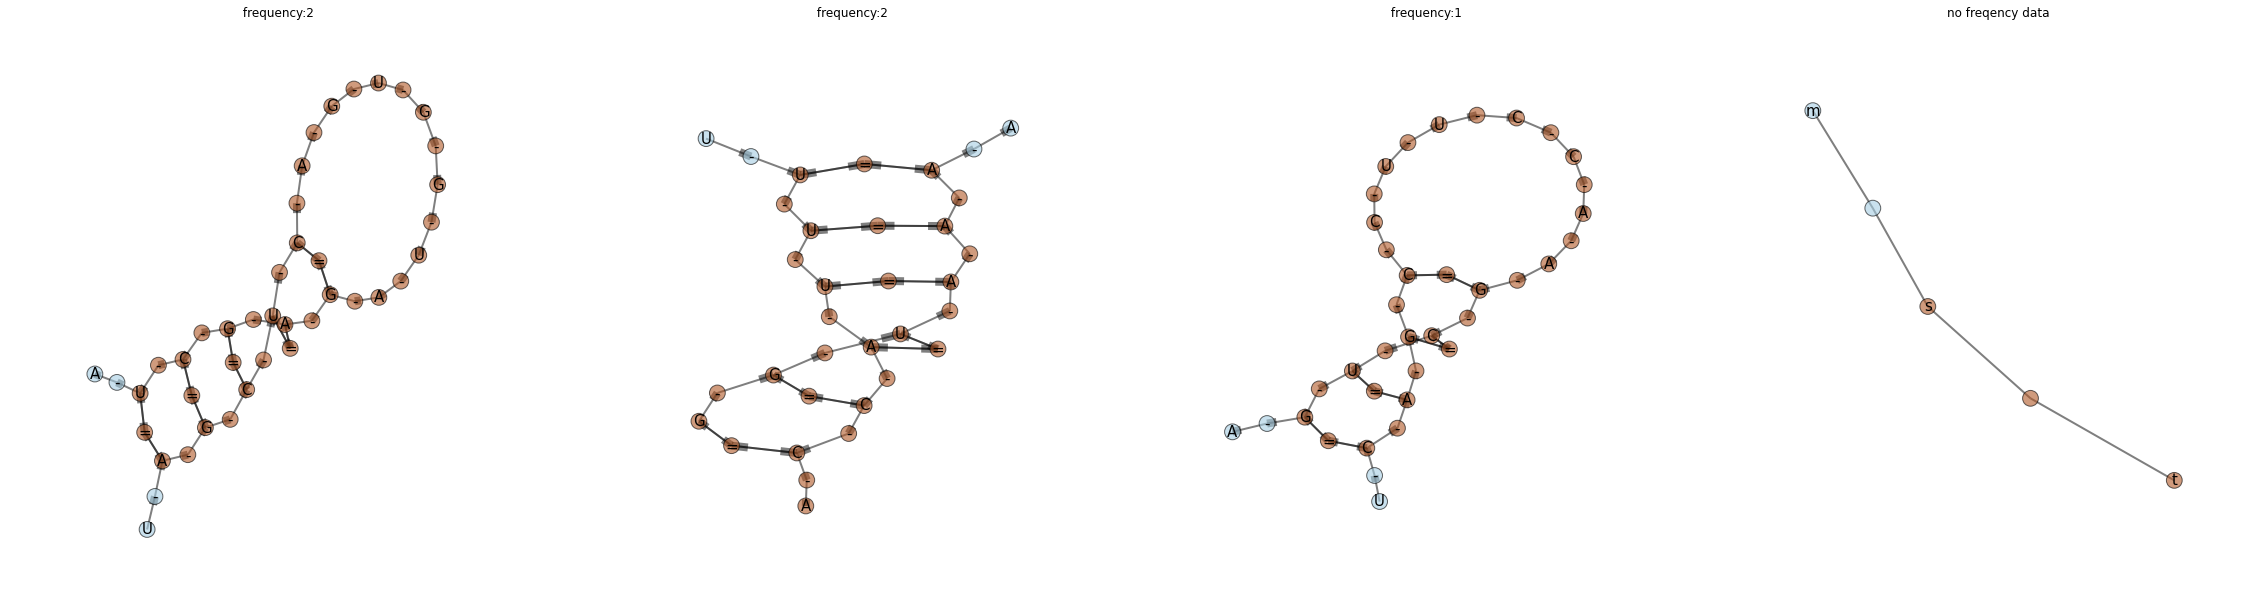

interface id: 439600 [22 options]


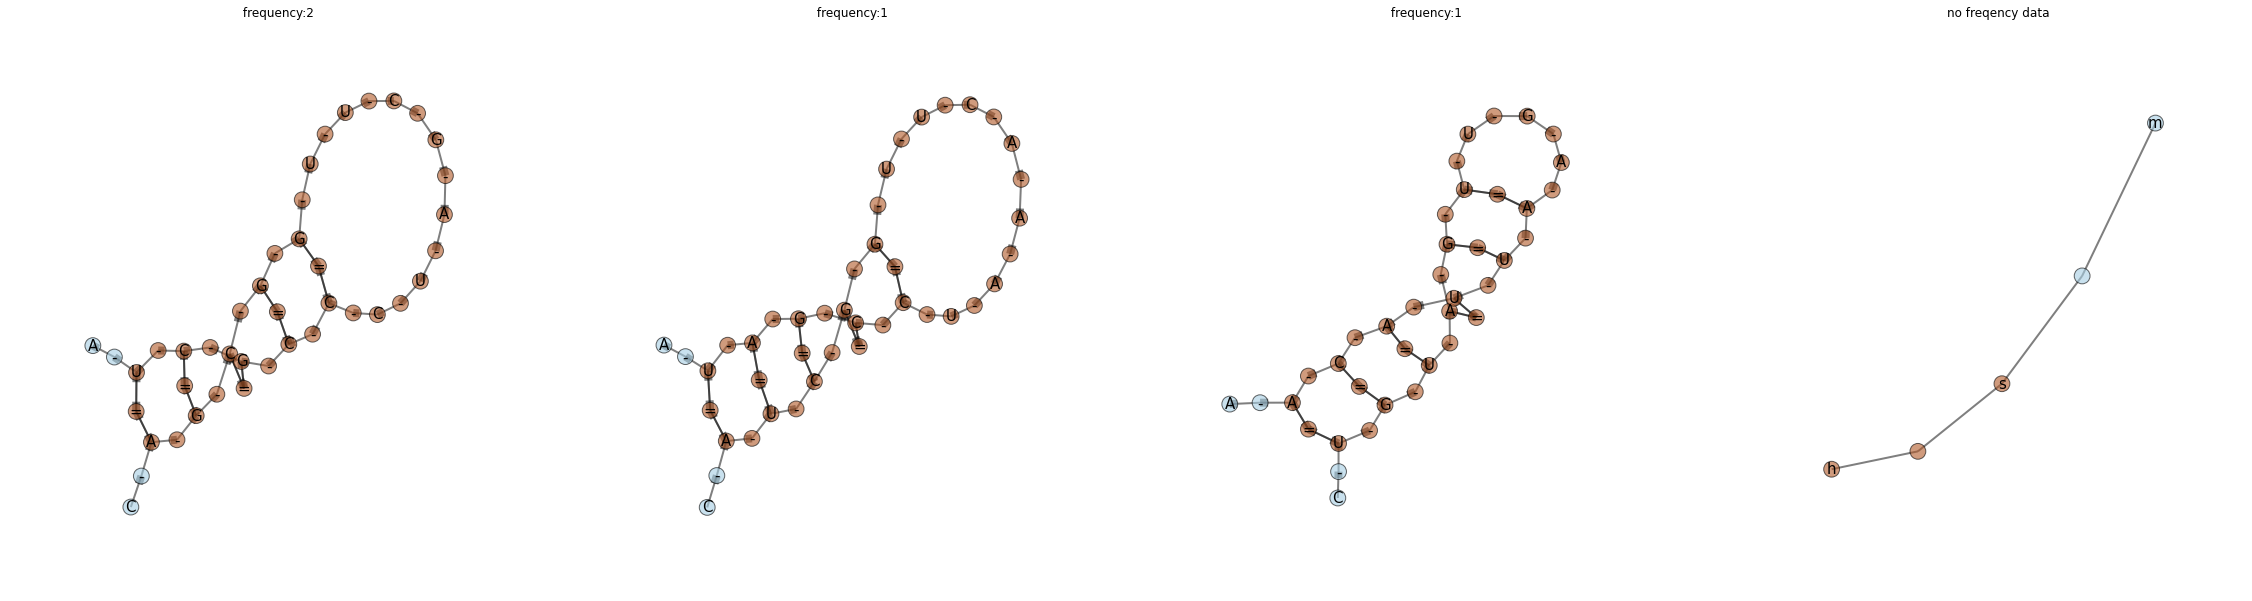

interface id: 75299 [20 options]


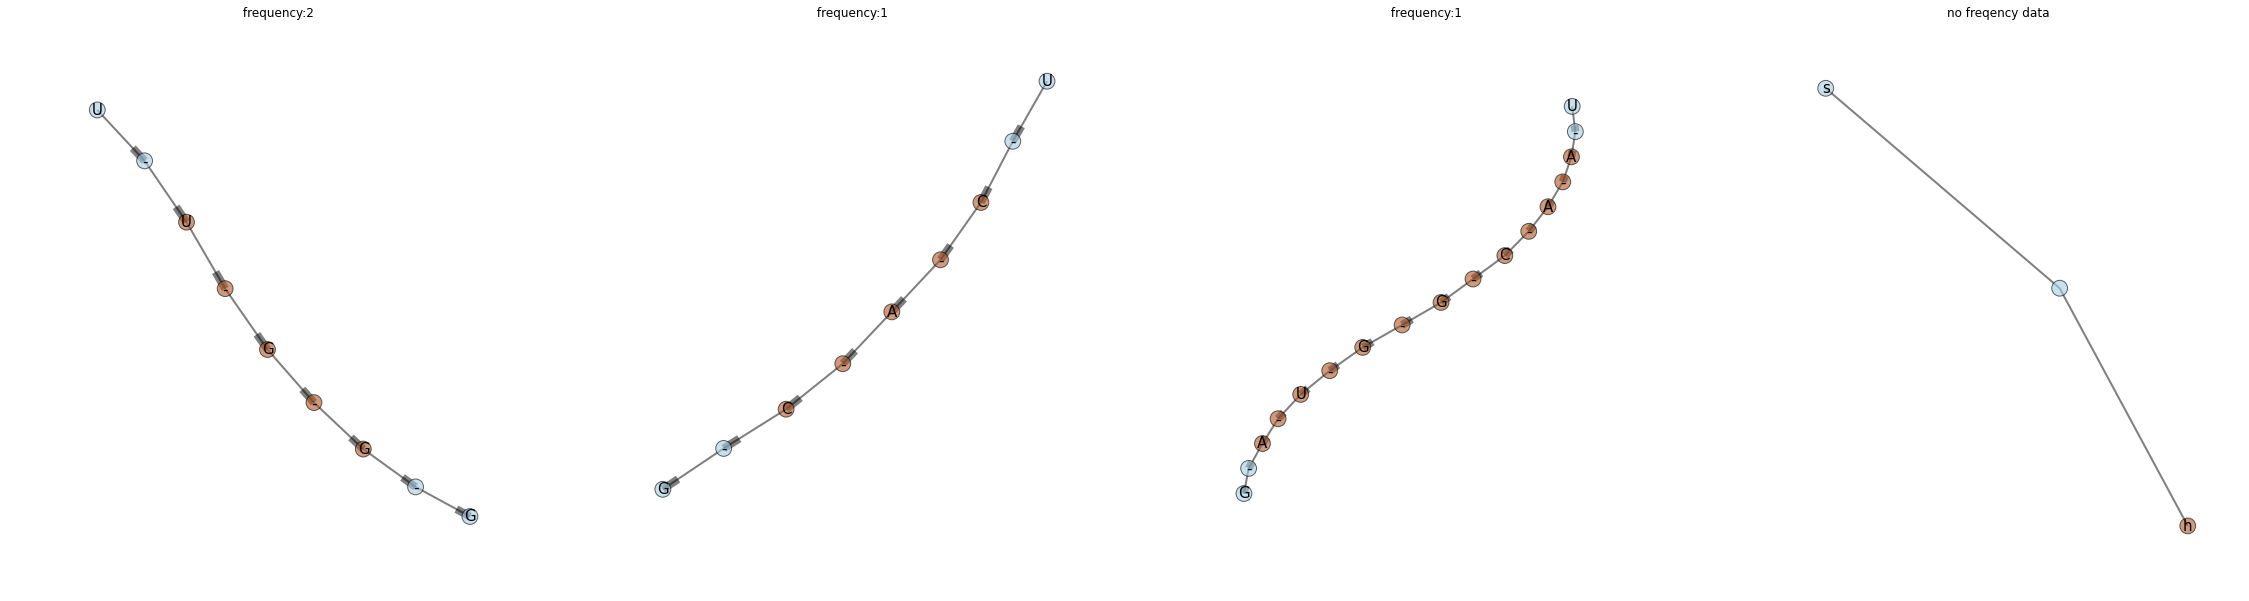

interface id: 616627 [18 options]


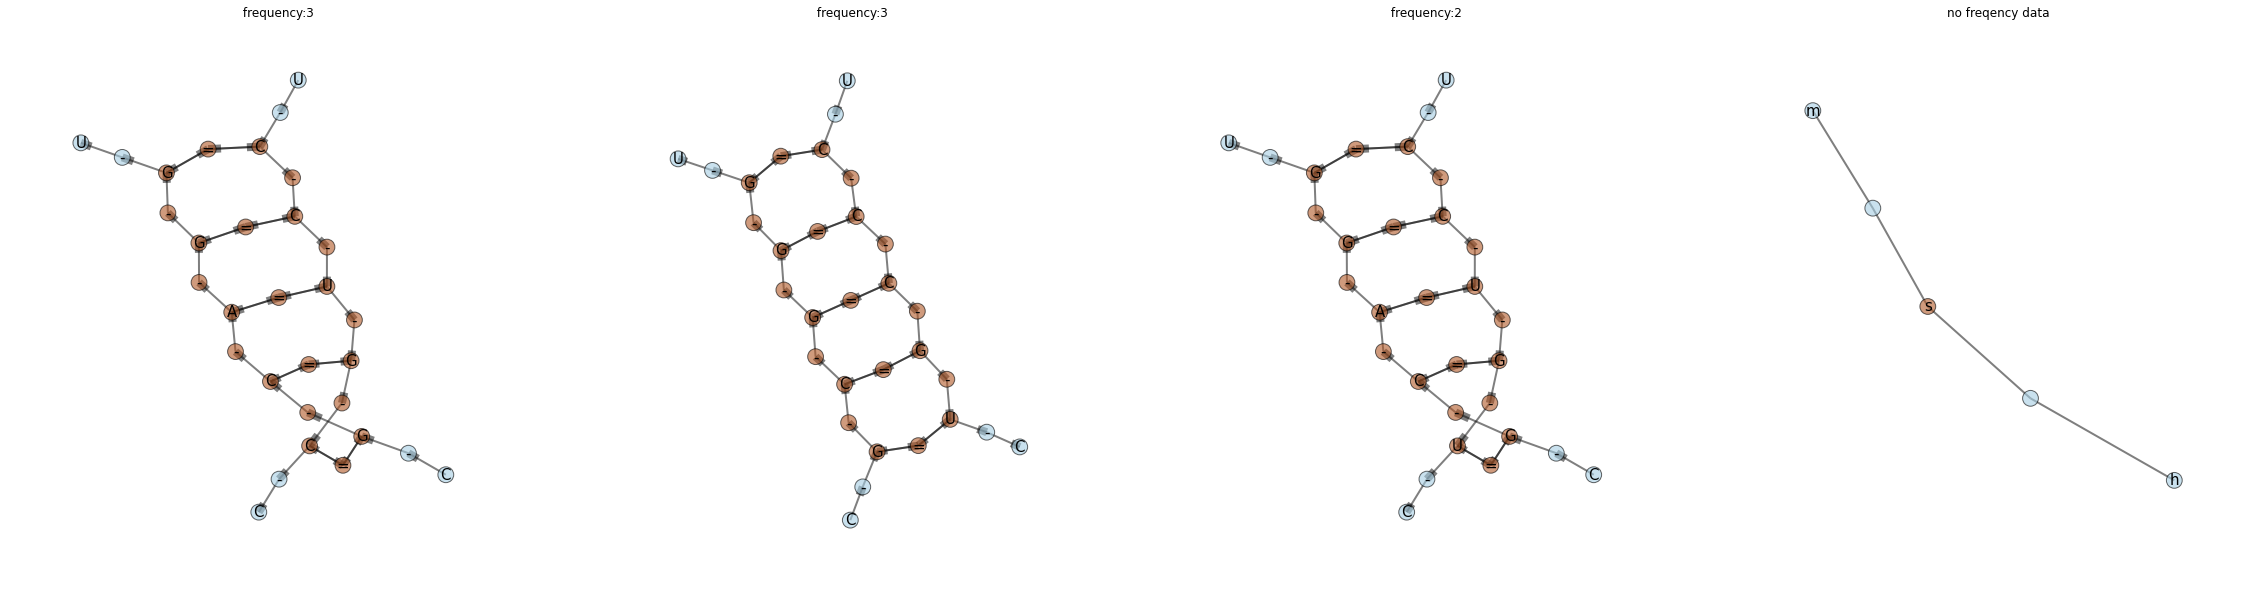

interface id: 323441 [18 options]


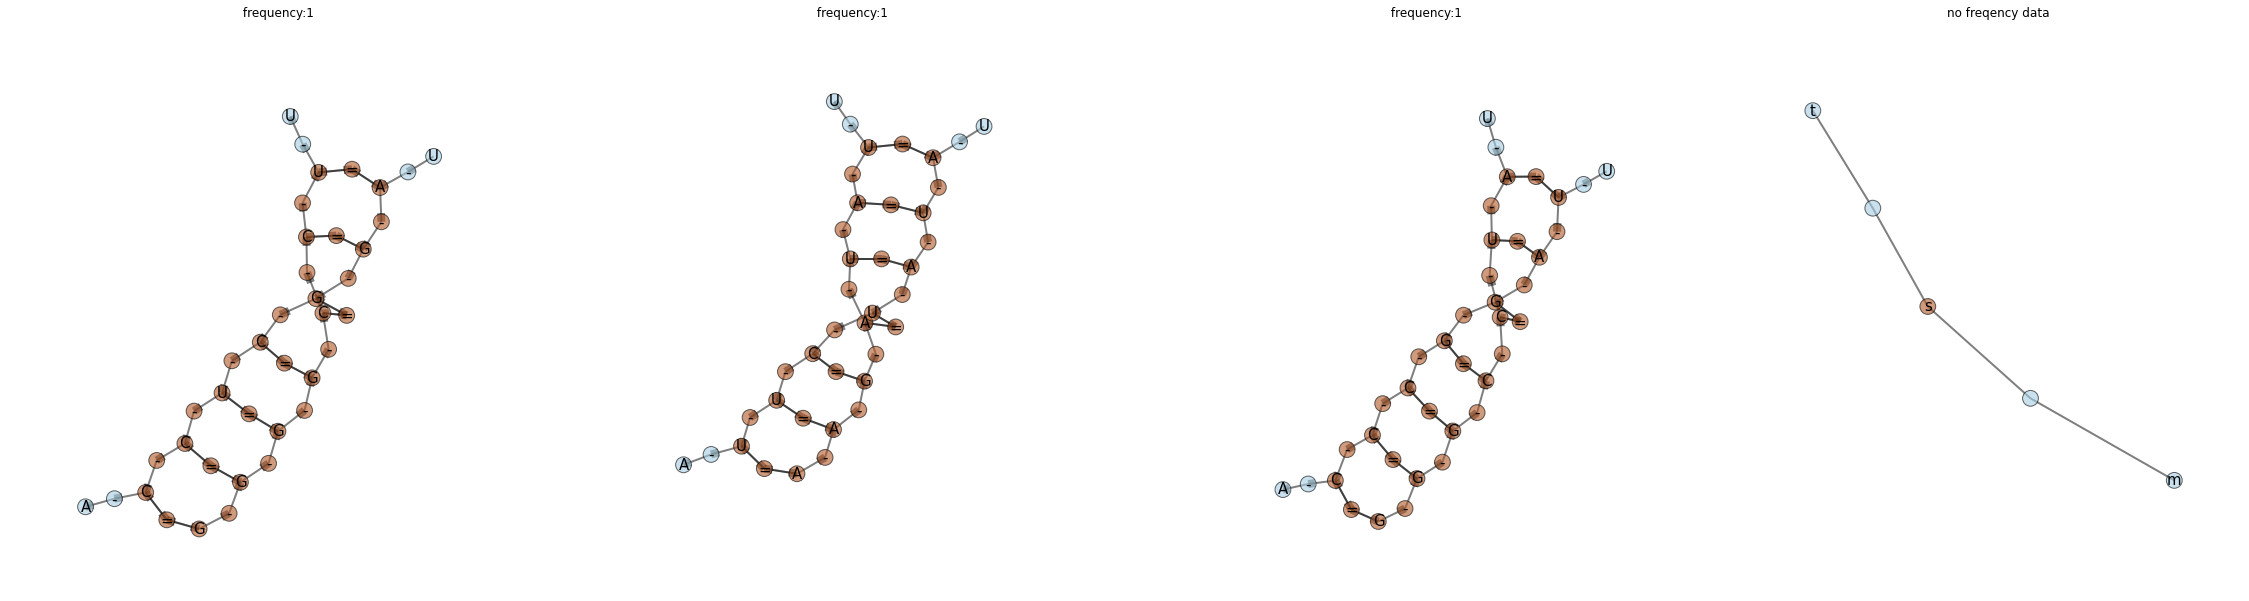

interface id: 936143 [15 options]


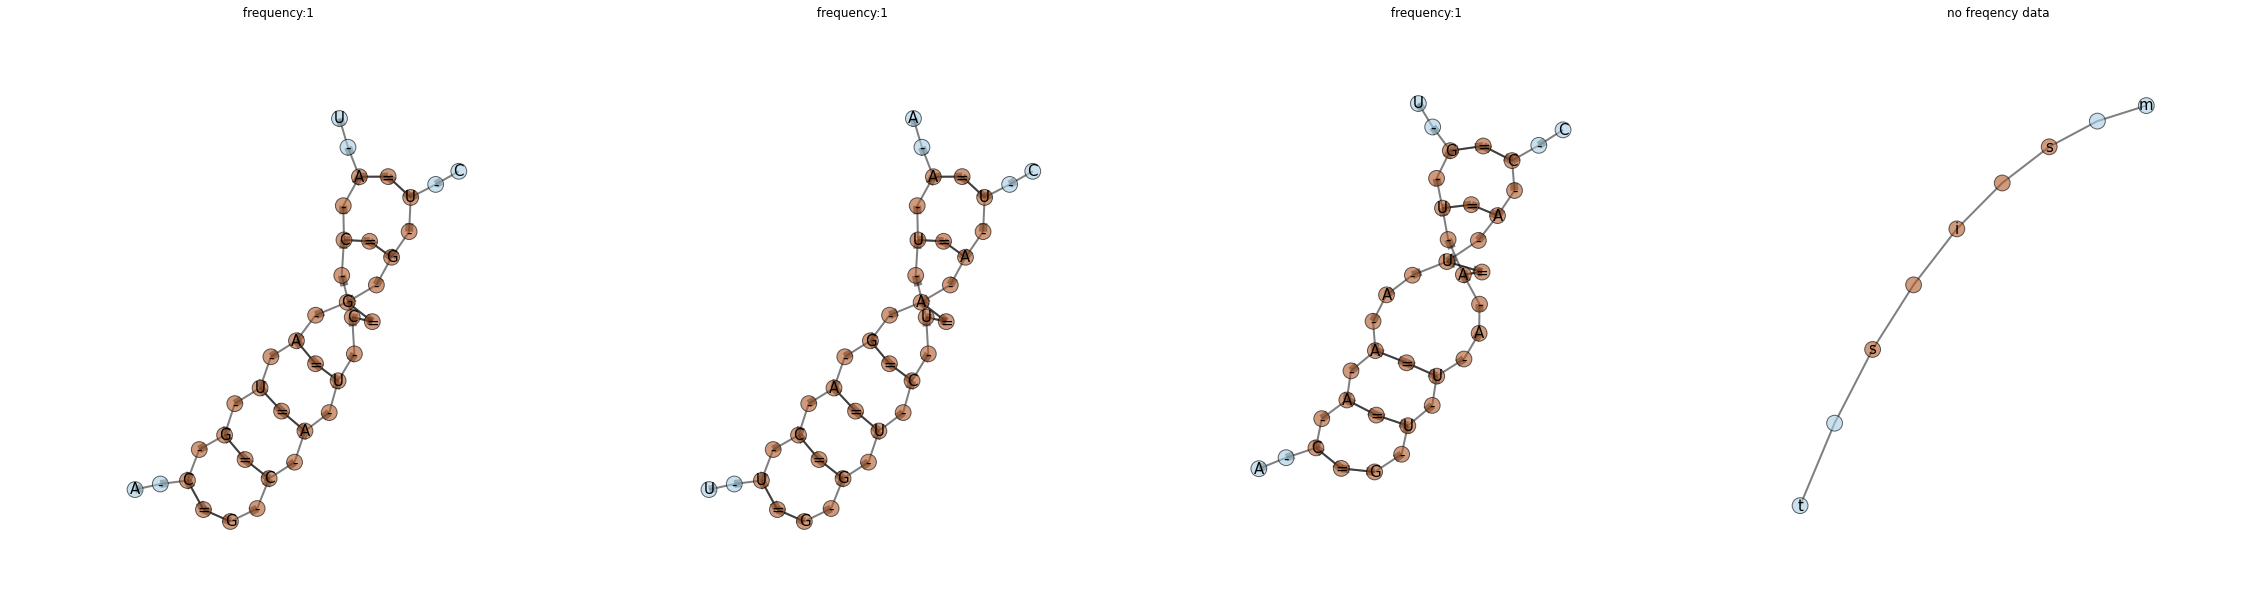

interface id: 826901 [15 options]


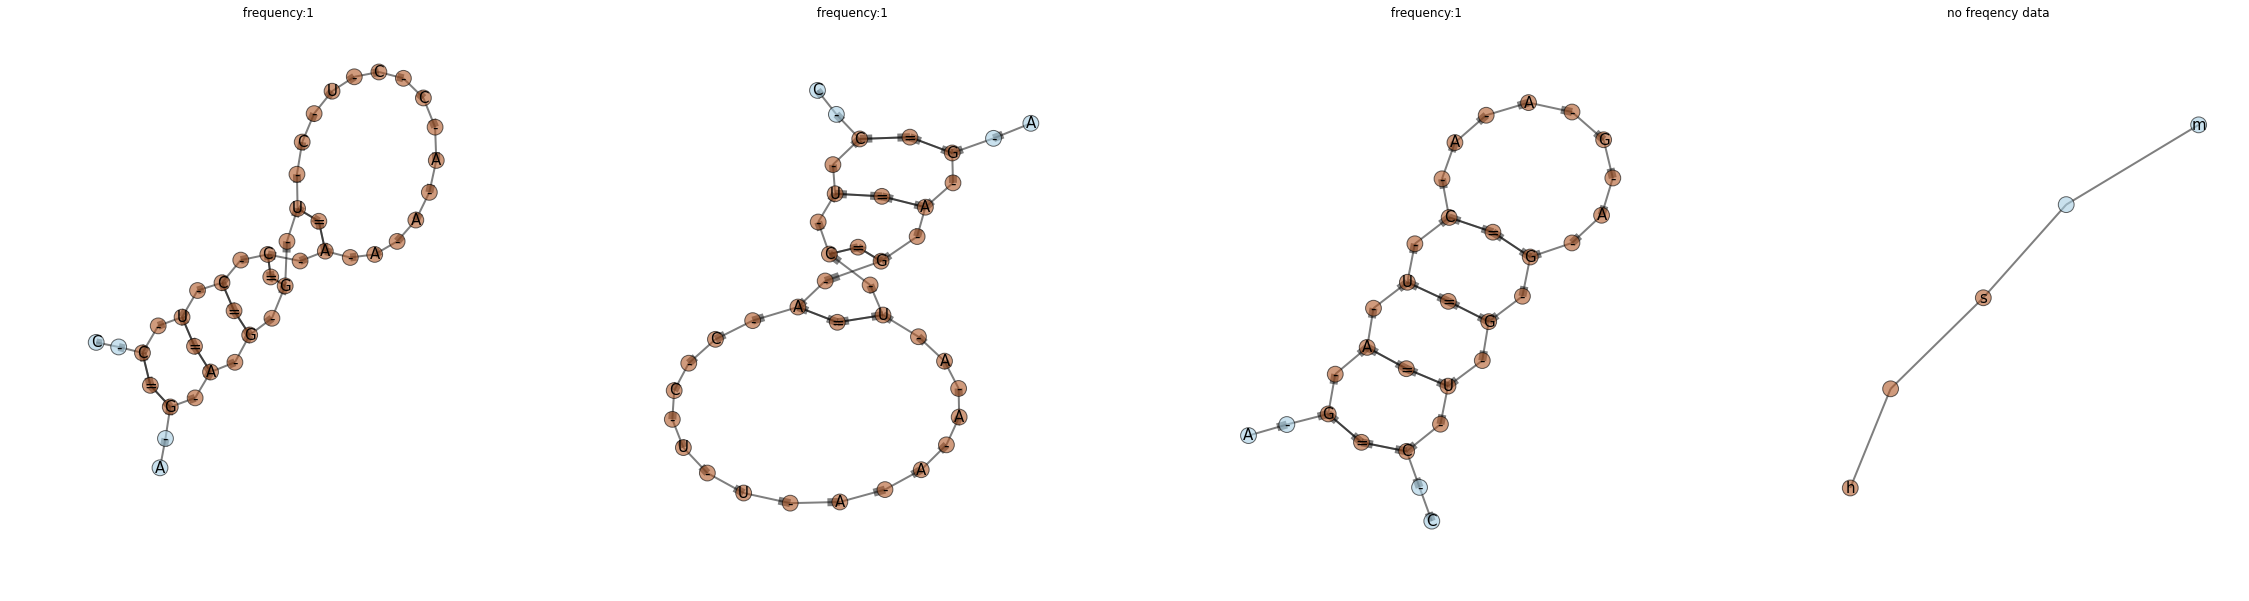

interface id: 432532 [13 options]


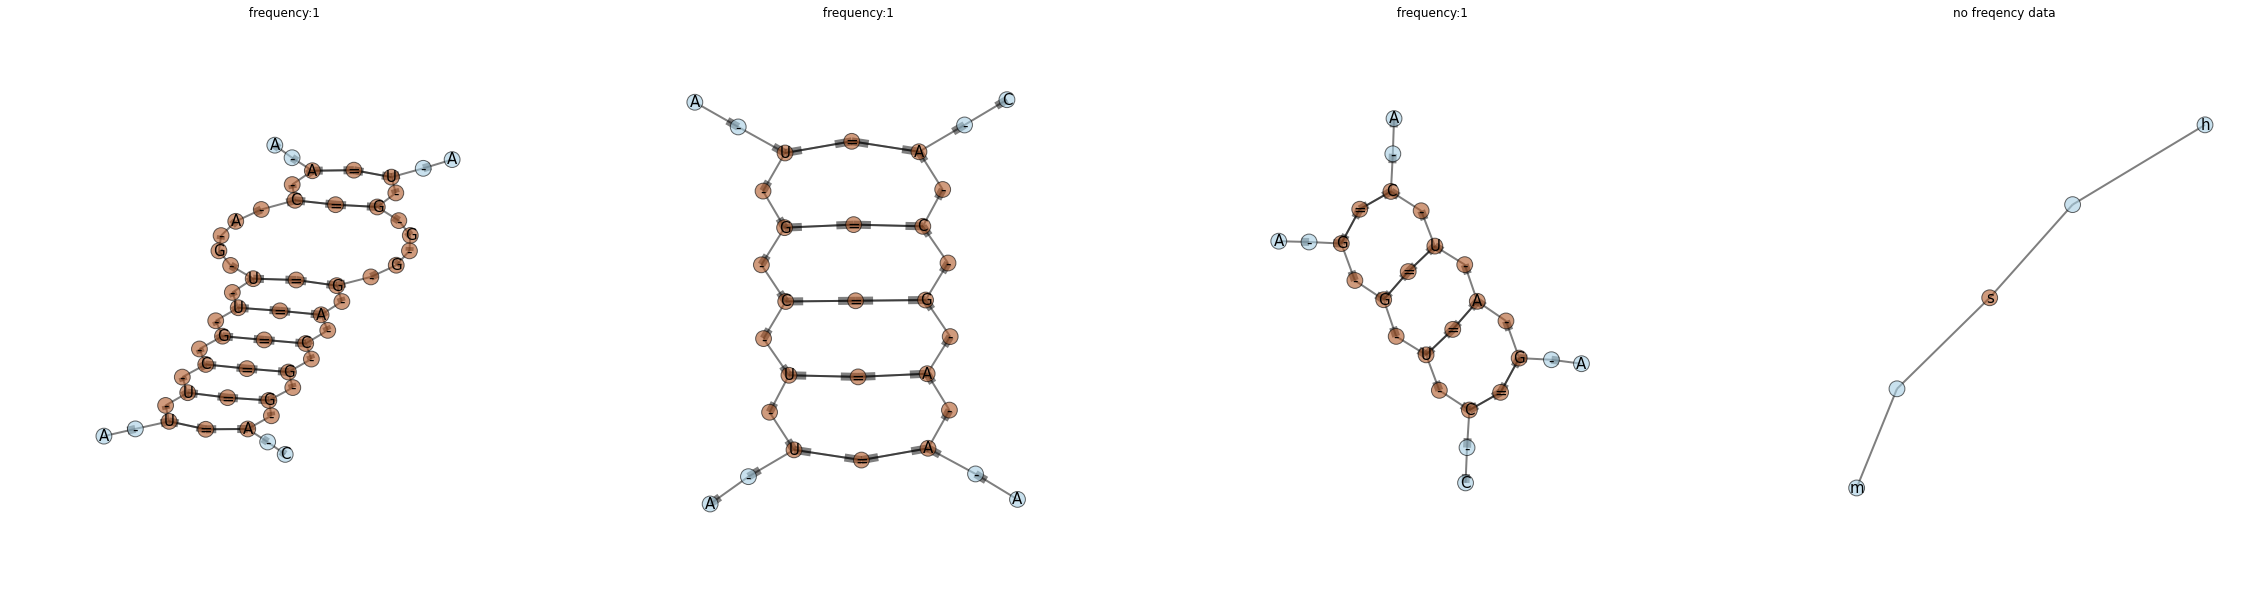

interface id: 46144 [13 options]


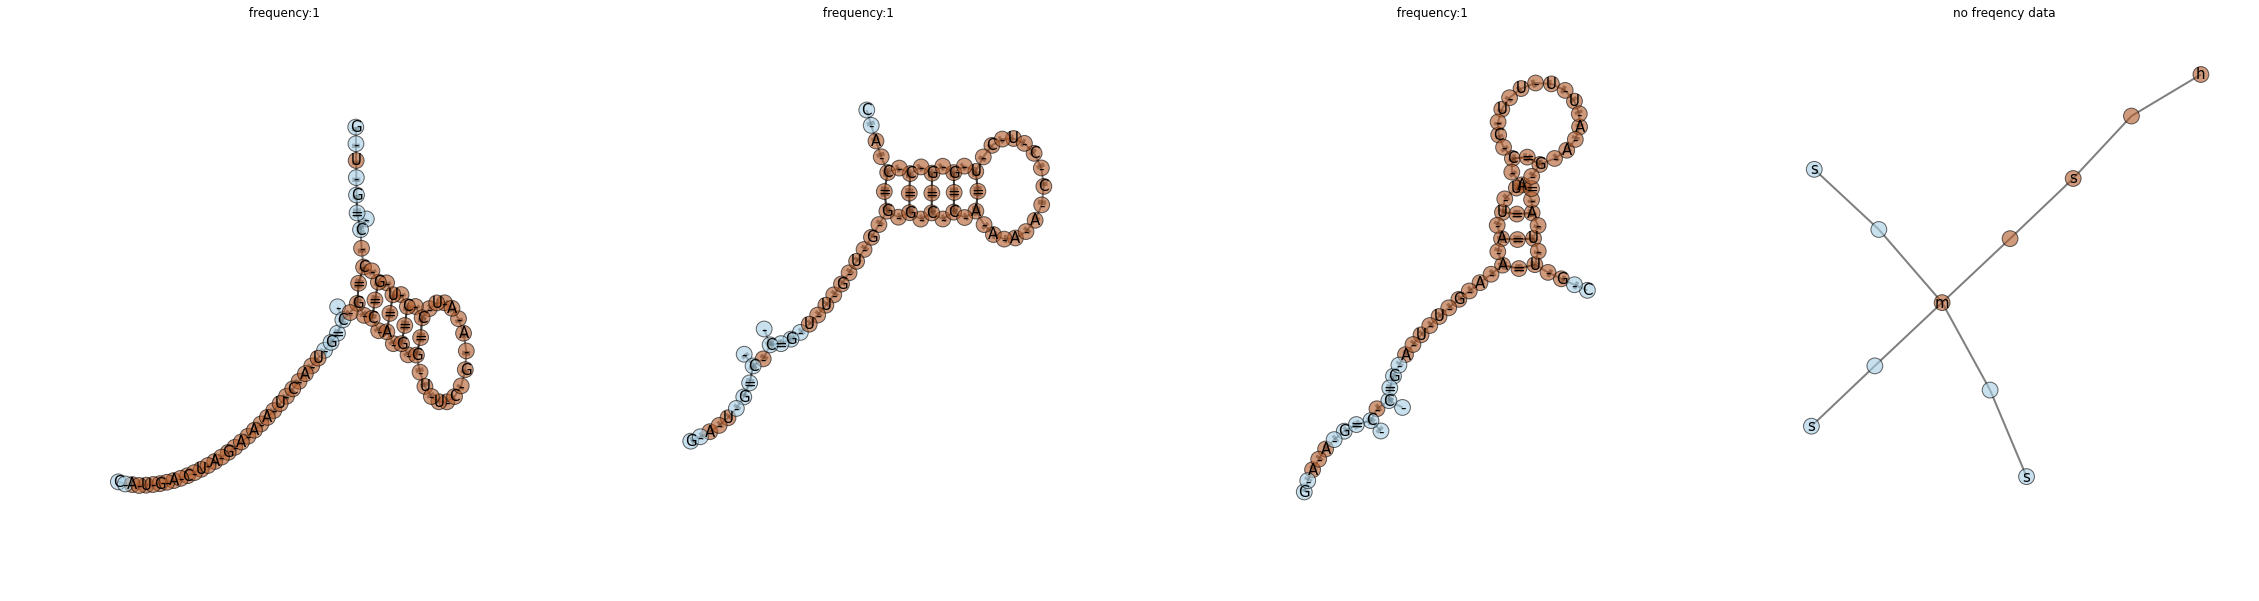

interface id: 835349 [12 options]


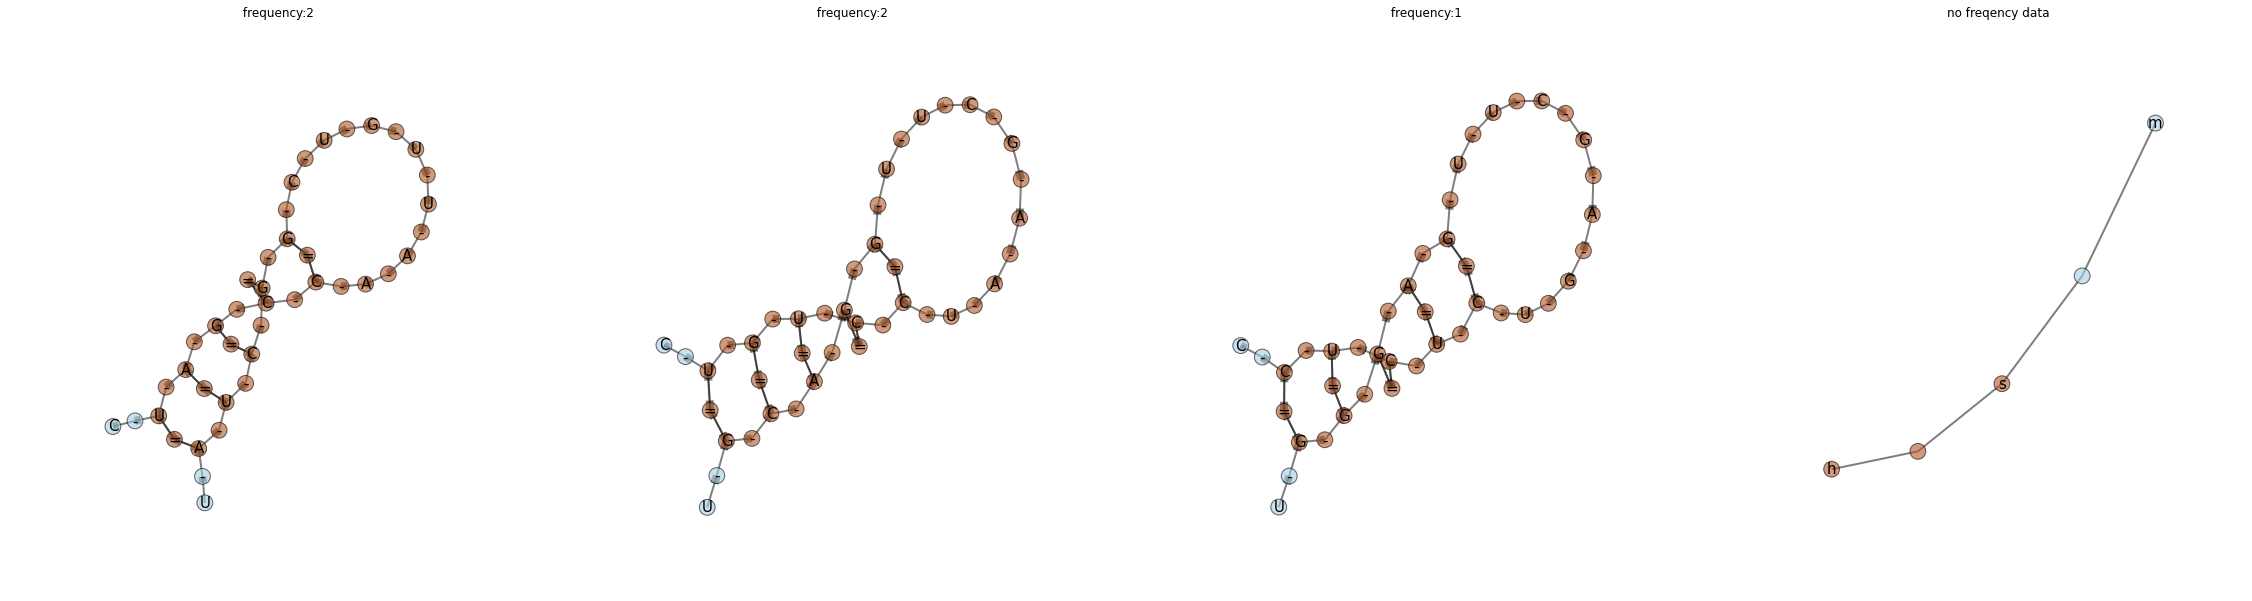

In [26]:
#draw production rules
import graphlearn.utils.draw as draw
draw.draw_grammar(sampler.lsgg.productions,n_productions=20,n_graphs_per_production=3,
                     n_graphs_per_line=6, size=10, contract=False,
                     colormap='Paired', invert_colormap=False,node_border=1,
                     vertex_alpha=0.6, edge_alpha=0.5, node_size=250)

# also note that the last graph in a row is not actually a cip.
# the cips dont show their interface in the abstract graph. 
# the last graph in each row is showing that abstract interface in blue. 


Graph id: 15


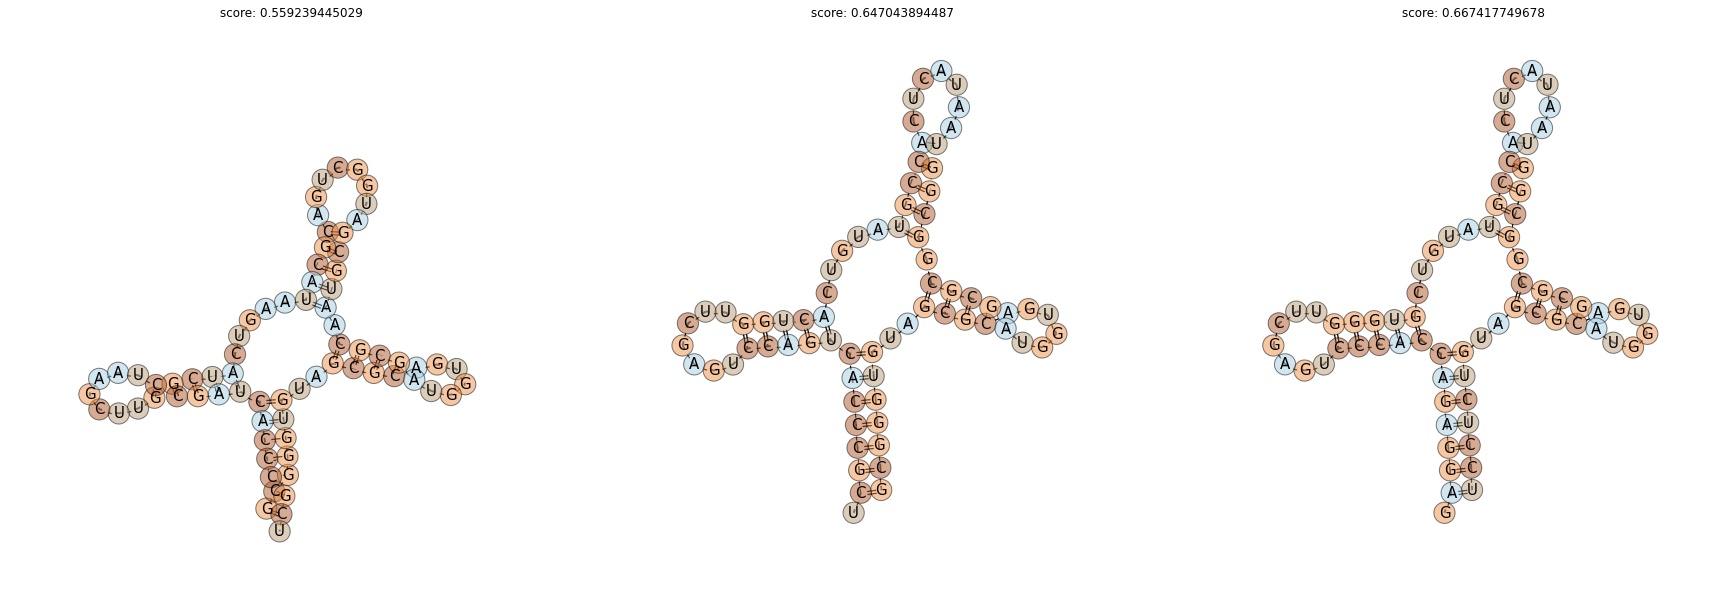

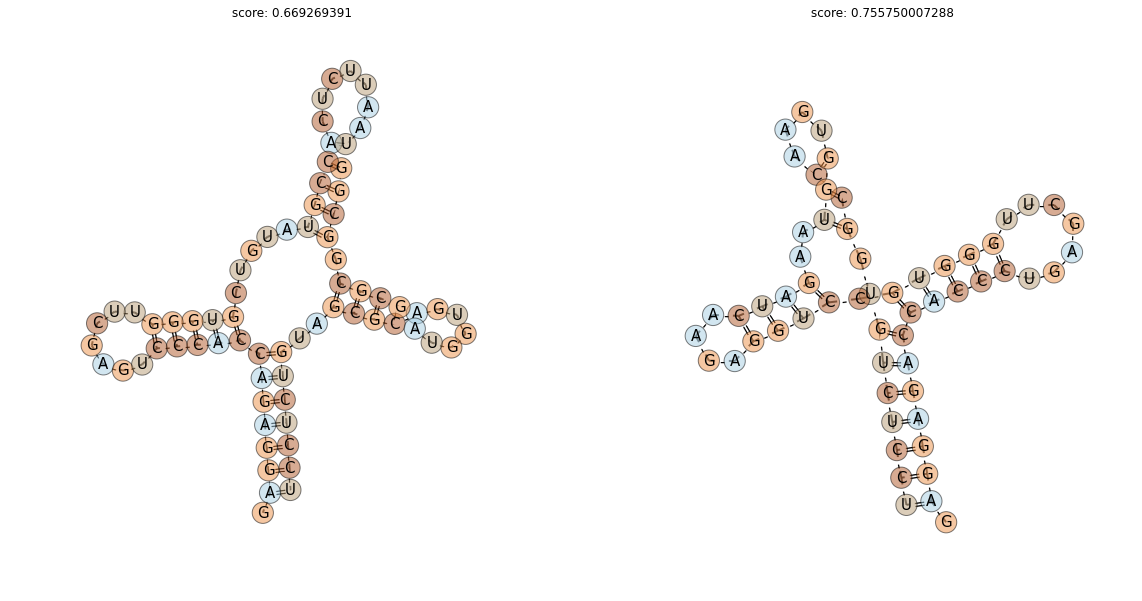

Graph id: 16


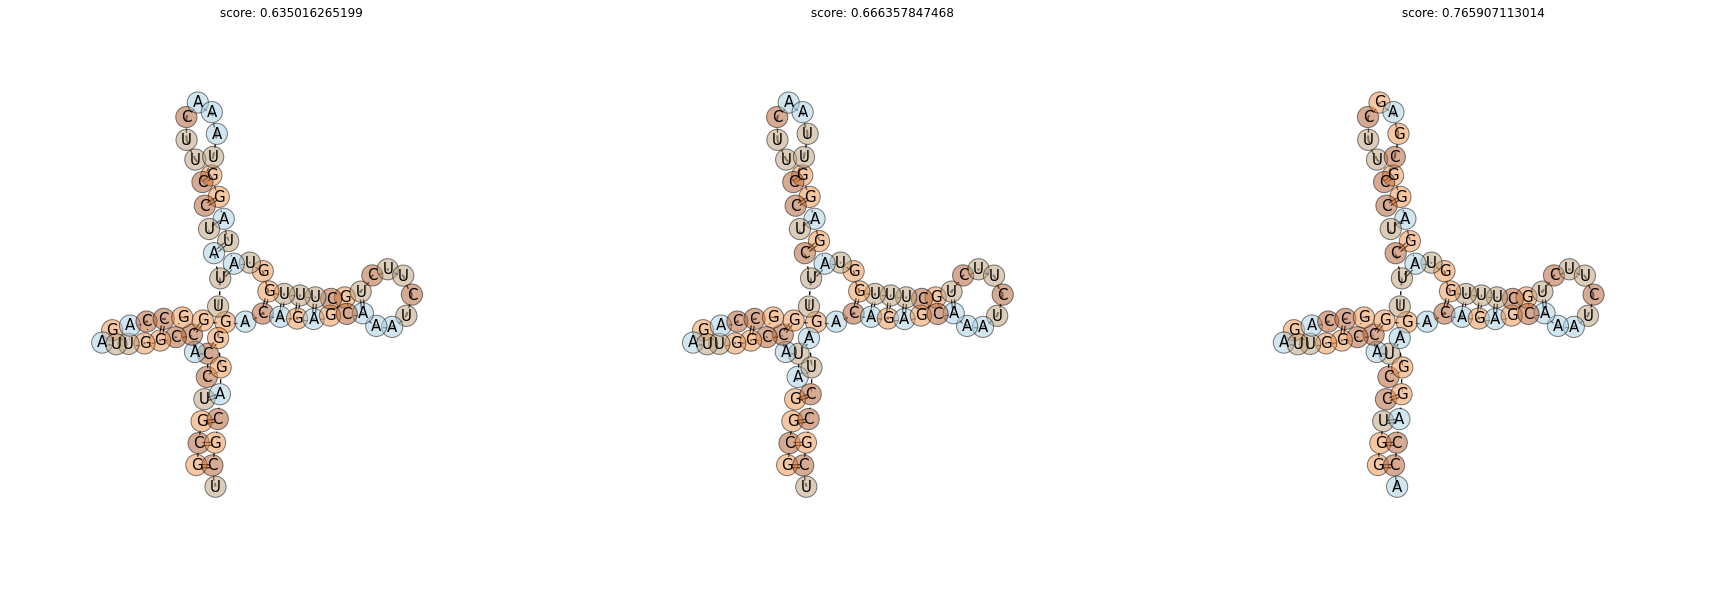

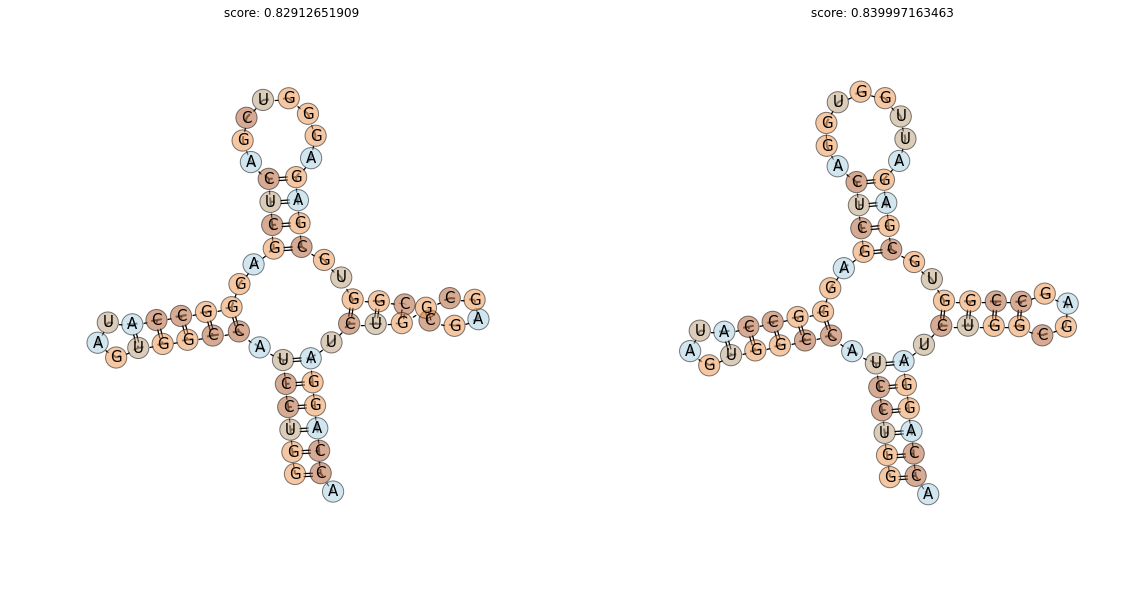

Graph id: 17


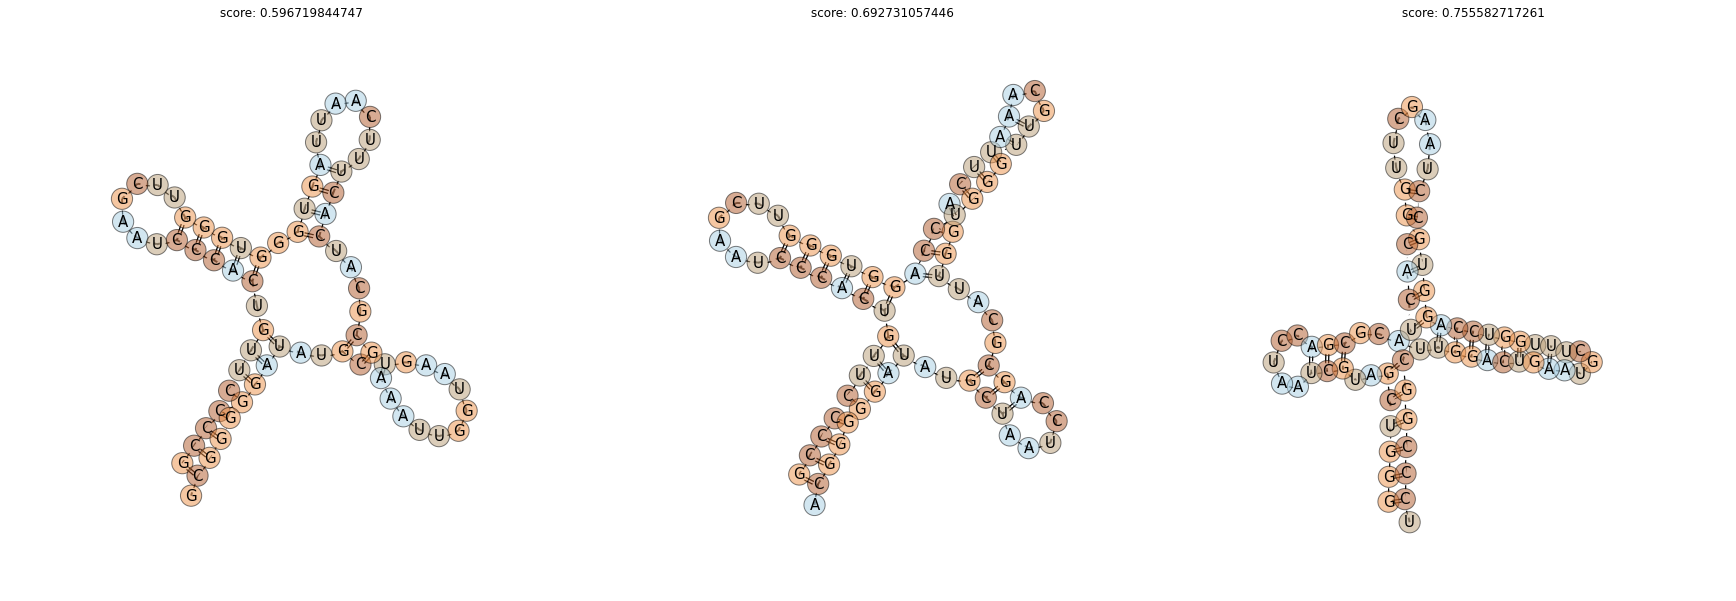

CPU times: user 37.5 s, sys: 4.54 s, total: 42 s
Wall time: 1min 27s


In [30]:
%%time
'''
RNA sampling

sampling works by taking input graphs, selecting a cip and see if we find a matching interface in 
the ciplist we created earlier. if we do, we can exchance the "core" part and see if the SVM likes 
what we created.
'''
import os
os.nice(19)
import graphlearn.utils.draw as draw
import graphlearn.abstract_graphs.rnasampler as rspl
import itertools
import matplotlib.pyplot as plt

# load what we created earlier
sampler=rspl.RNASampler()
sampler.load('tmp/rna_ubergrammar.ge')

# get input iterator
def fasta(filename='RF00005.fa'):
    s=[]
    with open(filename) as f:
        for line in f:
            s.append(line)
    while s:
        seqname=s[0]
        seq=''
        for i,l in enumerate(s[1:]):
            if l[0] != '>':
                seq+=l.strip()
            else:
                break
        yield seq  # the seq name is available but i dont feel like using it
        s=s[i+1:]
fasta_iter = fasta()


#  select input
id_start=15
id_end=id_start+3
fasta_iter = itertools.islice(fasta_iter,id_start,id_end)
n_steps=30

# run sampling
graphs = sampler.sample(fasta_iter,
                        n_samples=6,
                        batch_size=1,
                        n_steps=n_steps,
                        n_jobs=1,
                        quick_skip_orig_cip=True,
                        probabilistic_core_choice=True,
                        burnin=0,
                        improving_threshold=0.5,
                        select_cip_max_tries=200,
                        keep_duplicates=False)



# for all the output graphs, colorize and draw them , also save the score history of the sampling process
from eden.modifier.graph.vertex_attributes import colorize   
scores=[]
ids=range(id_start,id_end)
for i,graph in enumerate(graphs):
    print 'Graph id: %d'%(ids[i])
    scores.append(graph.graph['sampling_info']['score_history'])
    path_graphs = graph.graph['sampling_info']['graphs_history']
    path_graphs = colorize(path_graphs,
                           output_attribute = 'color_level', 
                           labels = ['A','U','G','C'])
    path_graphs= list(path_graphs)
    draw.graphlearn_draw(path_graphs,
                           n_graphs_per_line=3, size=10, 
                           colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                           vertex_alpha=0.5, edge_alpha=0.7, node_size=450,edge_label='label',
                          headlinehook= draw.get_score_of_graph
                          )

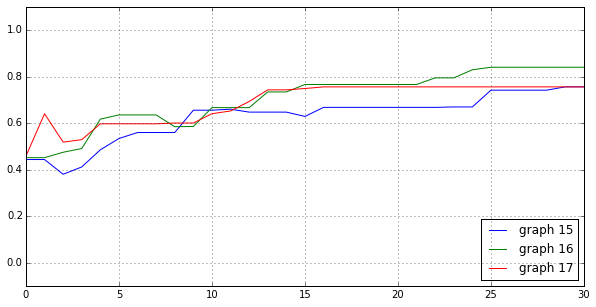

In [31]:
'''
draw the score history for each of the graphs
'''

%matplotlib inline
from itertools import islice
import numpy as np
step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(10,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
    plt.legend(loc='lower right')
    plt.grid()
    plt.ylim(-0.1,1.1)
    plt.show()